In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
import arviz as az

#import constants

from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [113]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_v2.txt', sep=" ", low_memory=False)

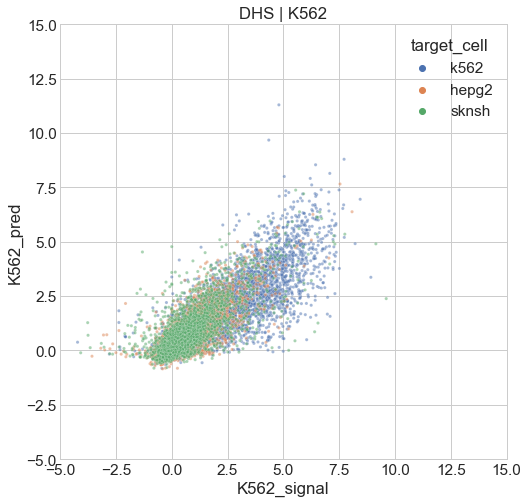

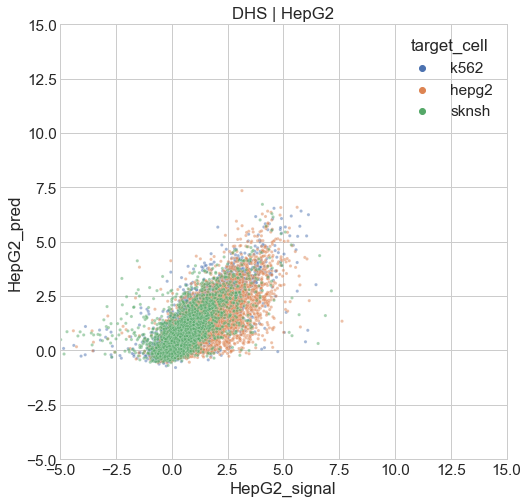

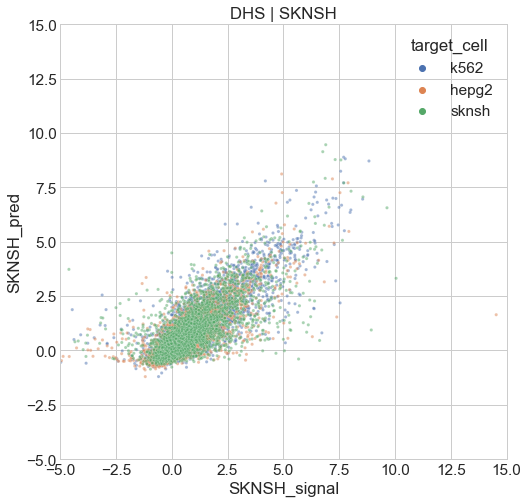

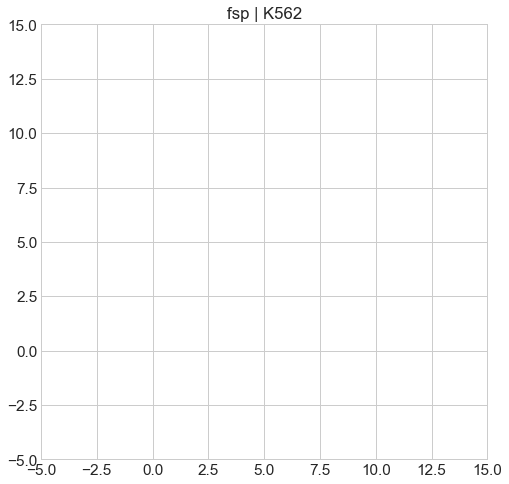

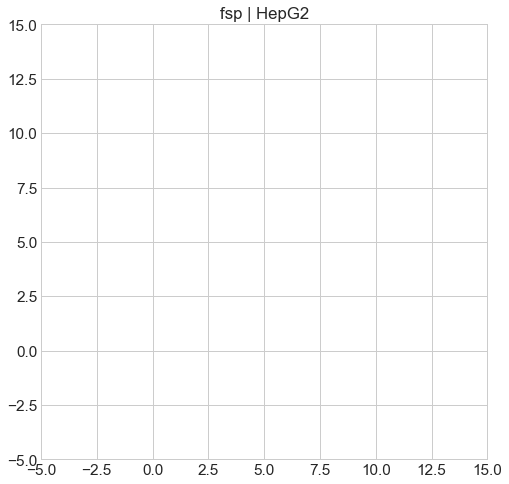

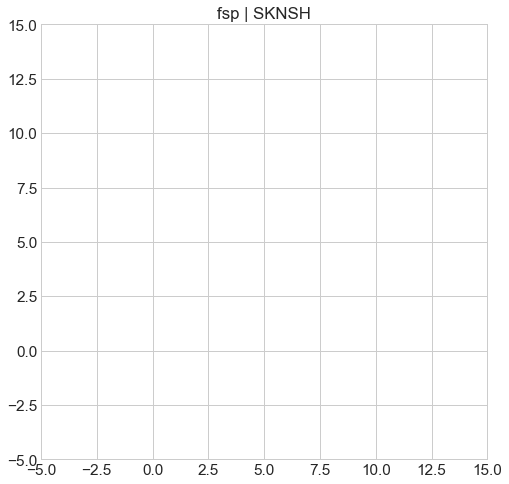

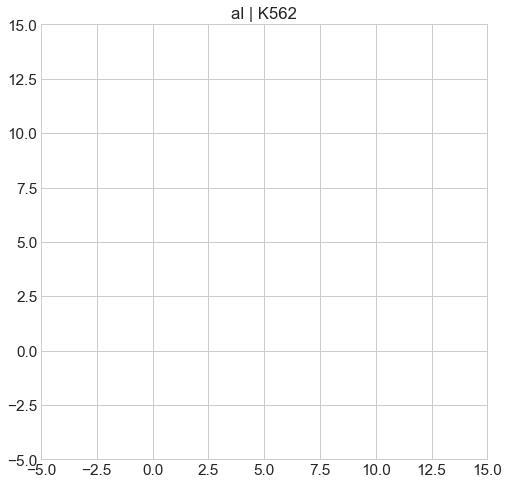

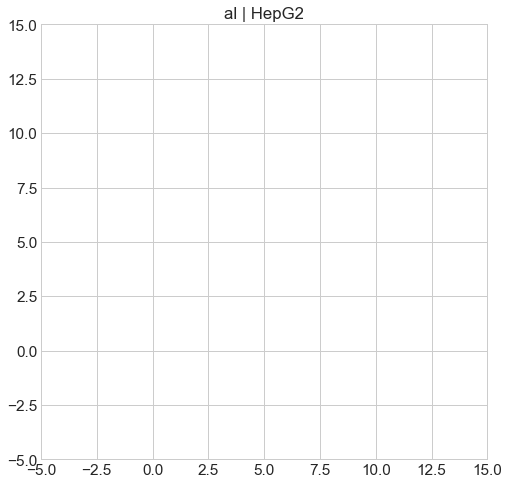

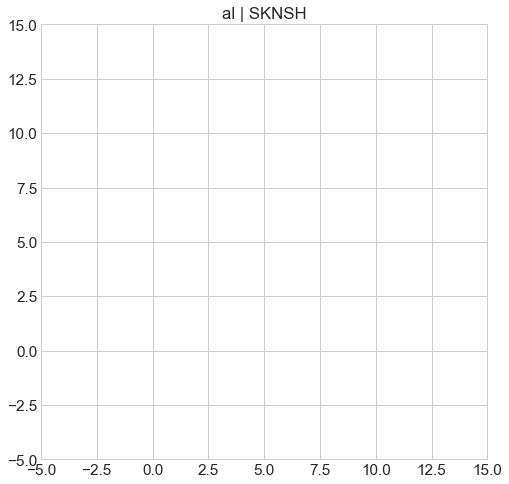

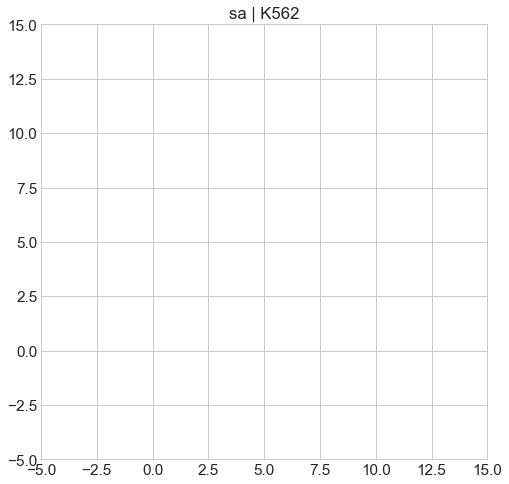

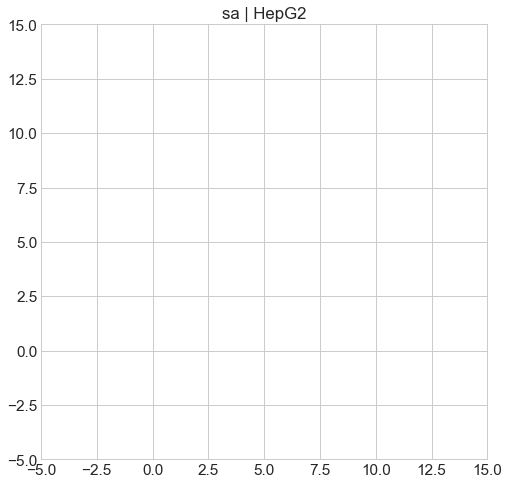

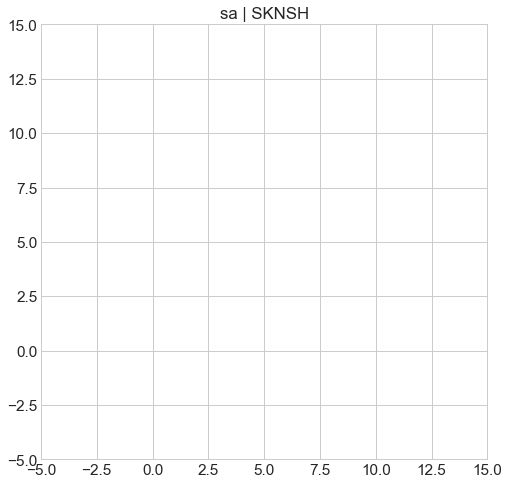

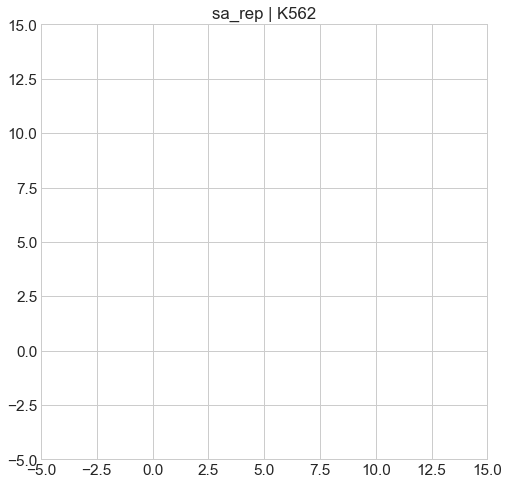

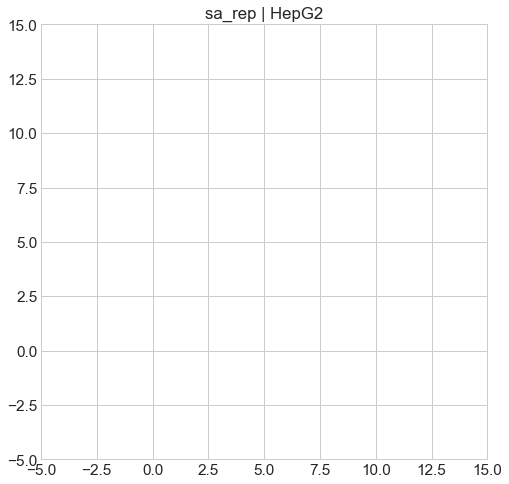

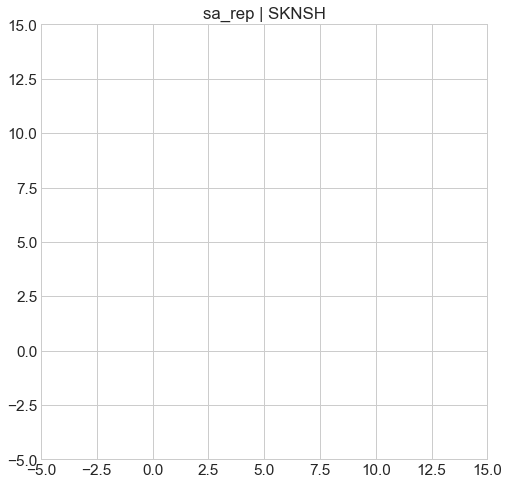

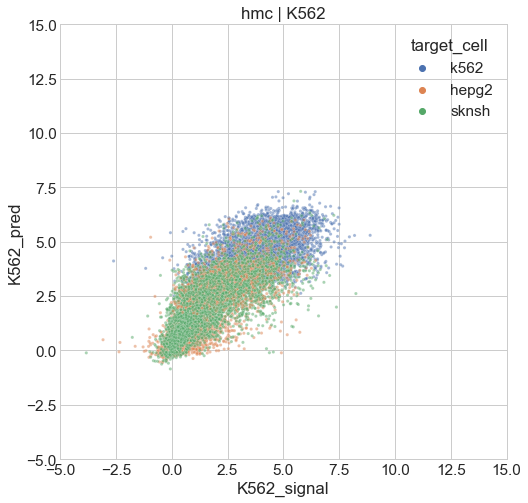

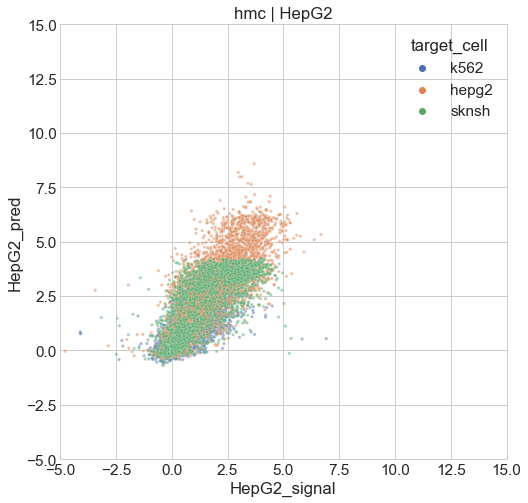

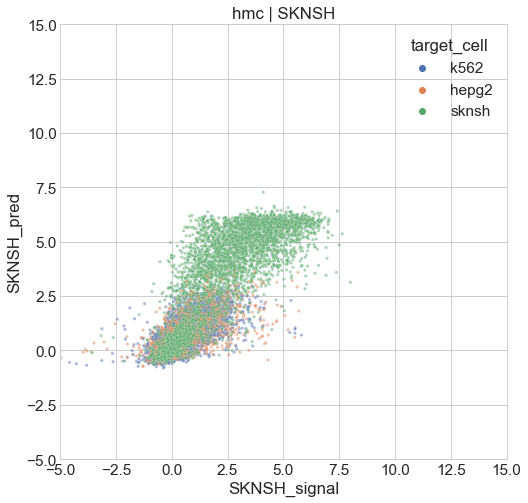

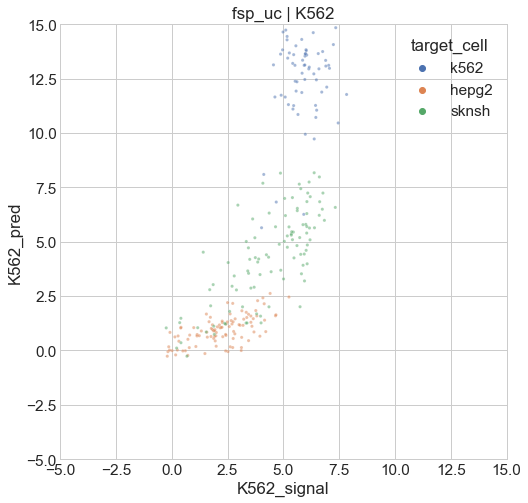

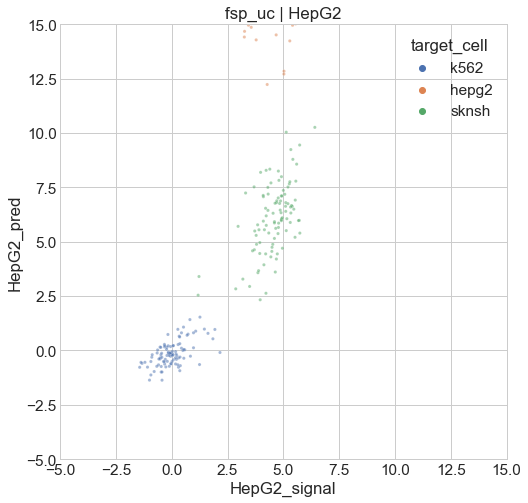

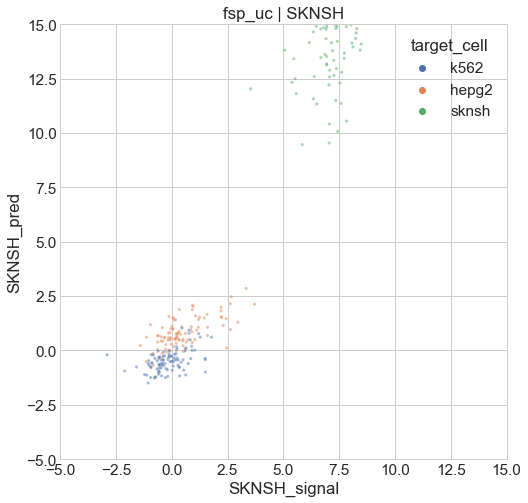

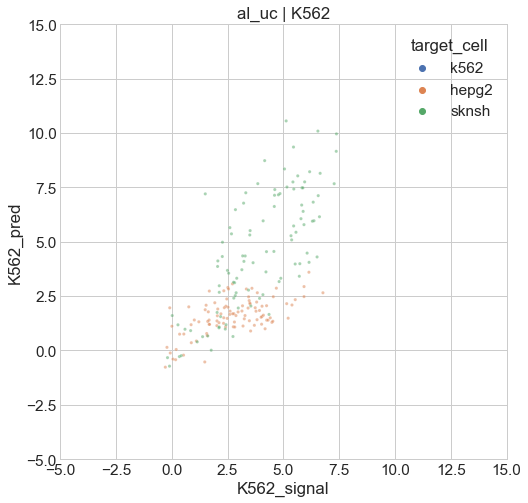

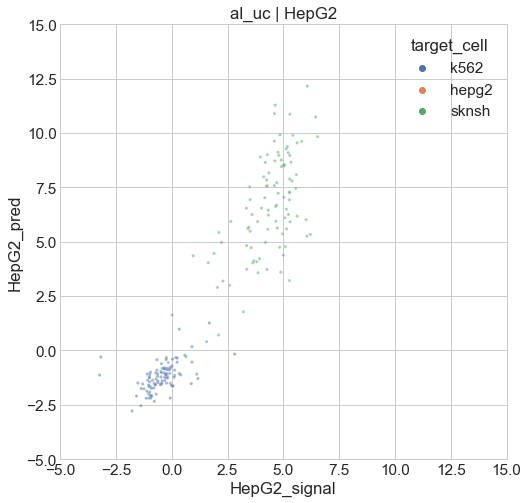

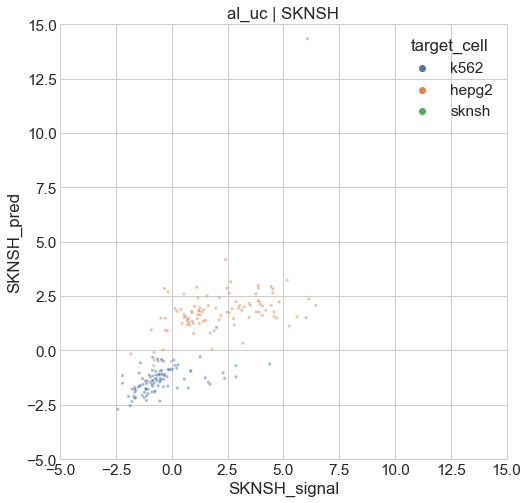

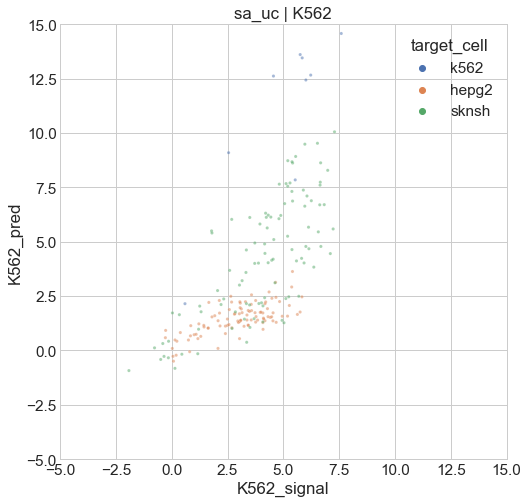

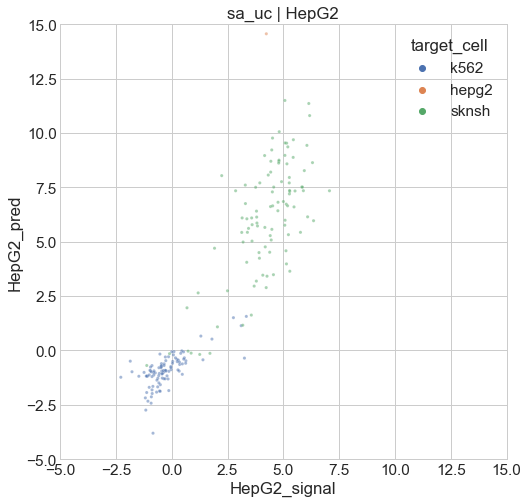

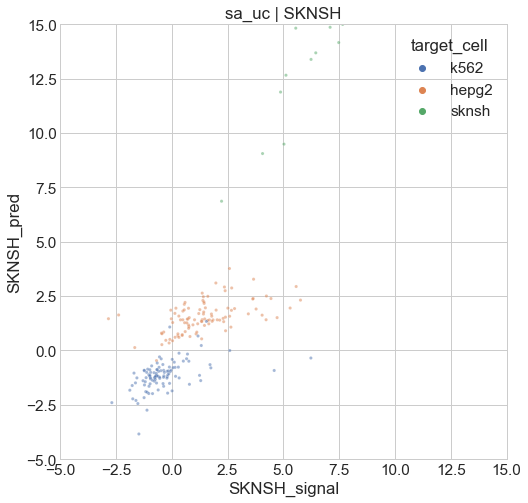

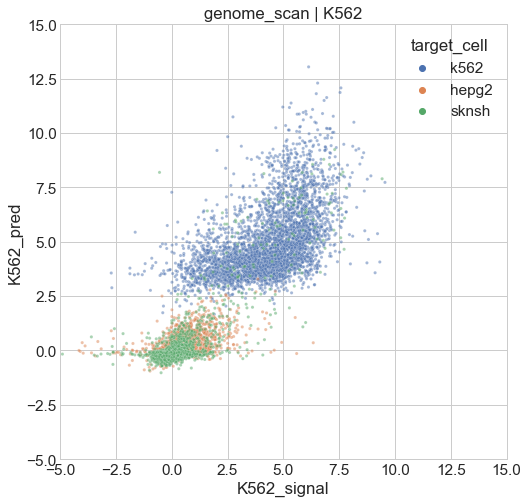

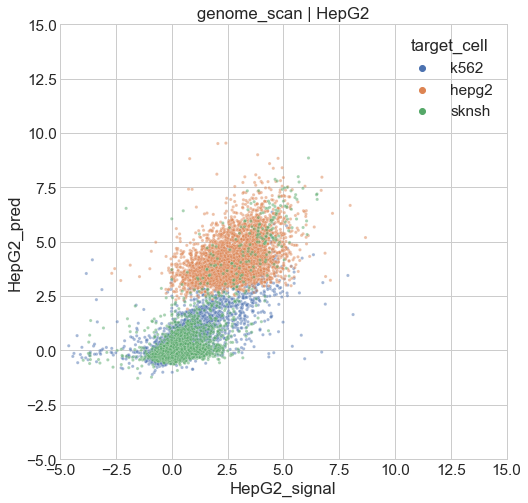

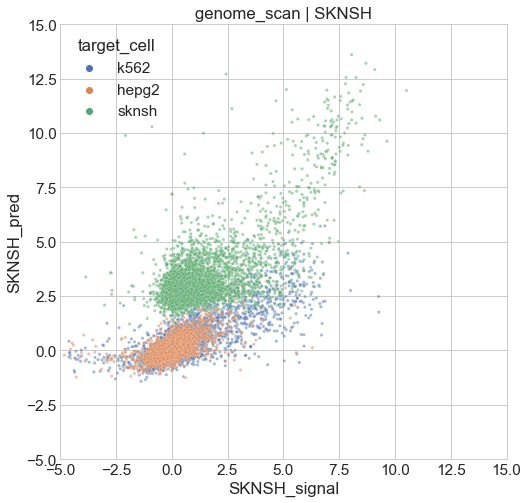

In [4]:
all_methods = ['DHS', 'fsp', 'al', 'sa', 'sa_rep', 'hmc', 'fsp_uc', 'al_uc', 'sa_uc', 'genome_scan']
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
#colormaps = ['winter', 'autumn', 'summer']
sns.set(font_scale = 1.4)
with plt.style.context('seaborn-whitegrid'):
    for method in all_methods:
        if method in ['fsp', 'al', 'sa', 'sa_rep']:
            row_filter = (boda2_df['method'] == method) & (boda2_df['round'] == '0')
        else:
            row_filter = (boda2_df['method'] == method)
        plot_df = boda2_df[row_filter].copy()
        for color_idx, cell_type in enumerate(cell_types):   
            plt.figure(figsize=(8,8))
            sns.scatterplot(data=plot_df, x=f'{cell_type}_signal', y=f'{cell_type}_pred', hue='target_cell', s=10.0, alpha=0.5,
                           hue_order=target_cells)
            #plt.plot((-5,15), (-5,-15), color='black', linestyle='--', alpha=0.5)
            plt.xlim(-5,15)
            plt.ylim(-5,15)
            plt.title(f'{method} | {cell_type}')#, fontsize=16)
            plt.show()
            #plot_df.plot(kind='scatter', x=f'{cell_type}_signal', y= f'{cell_type}_pred', color=f'C{color_idx}')
    #         single_scatterplot(plot_df, x_axis=f'{cell_type}_signal', y_axis=f'{cell_type}_pred', color_axis=f'{cell_type}_lfcSE',
    #                         dot_size=1.0, fig_size=(12,8), colormap=colormaps[color_idx], title=f'{method}')
    #         plt.gca().set_aspect('equal', adjustable='box')
    #         plt.show()

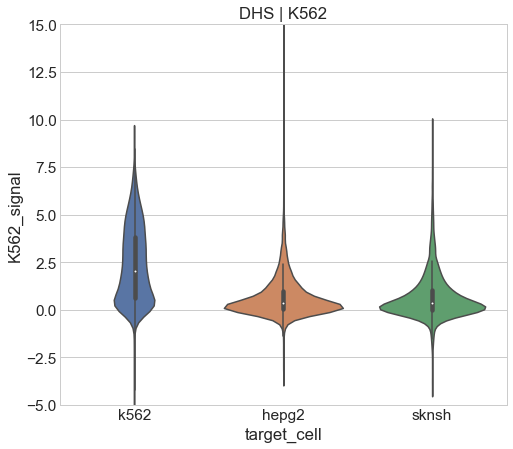

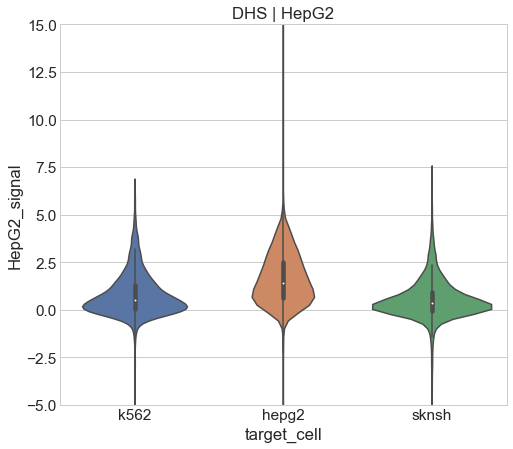

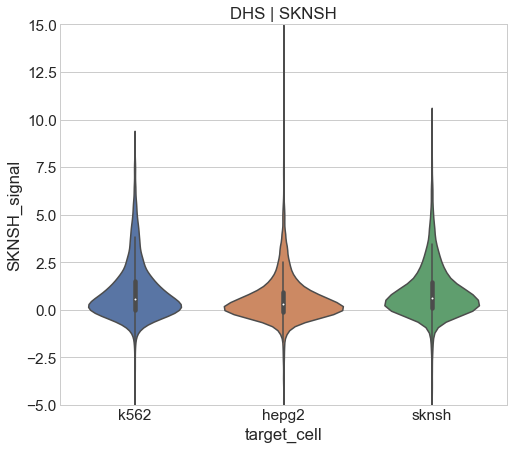

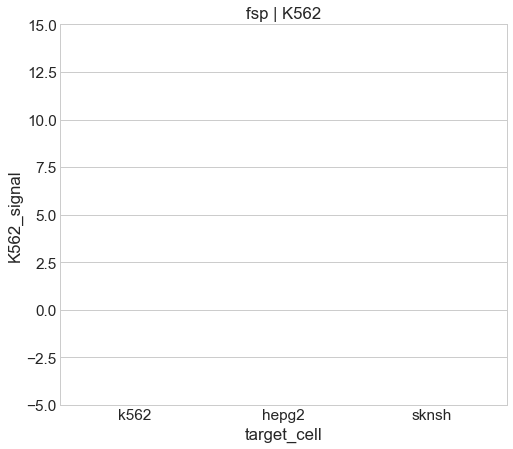

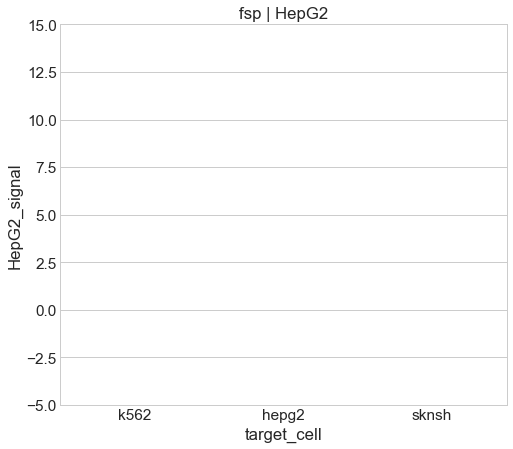

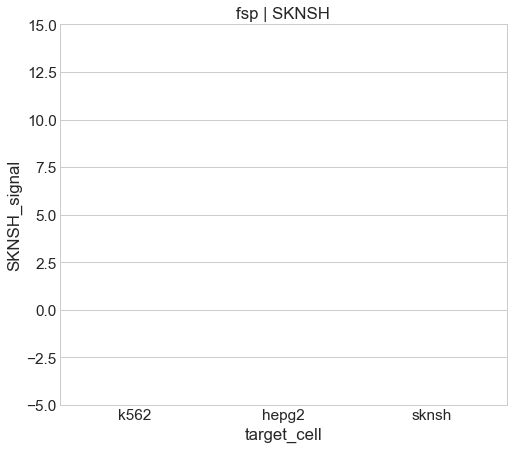

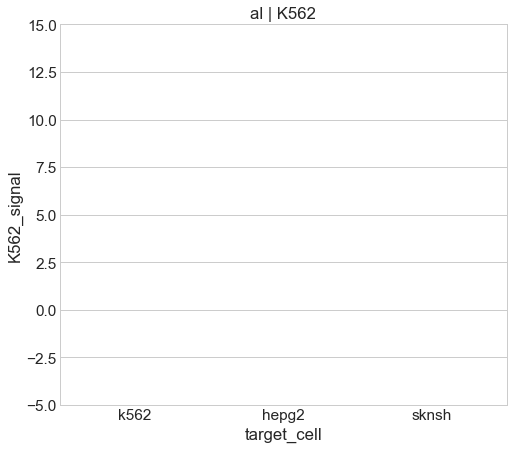

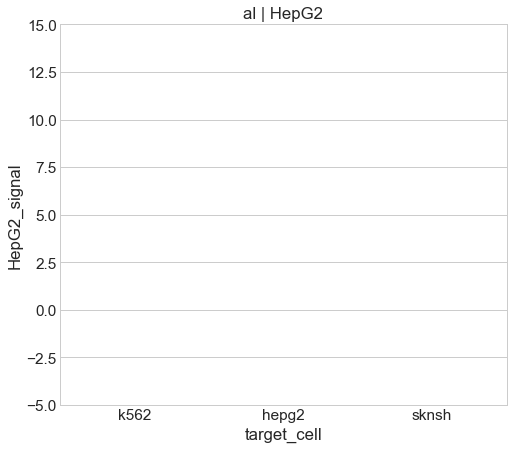

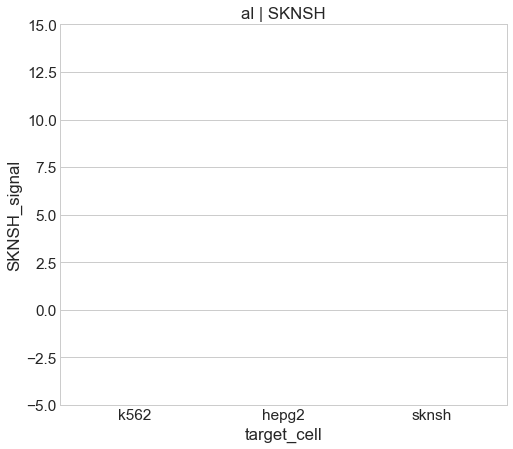

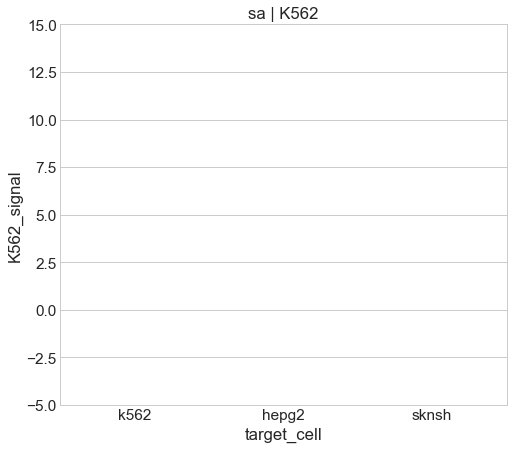

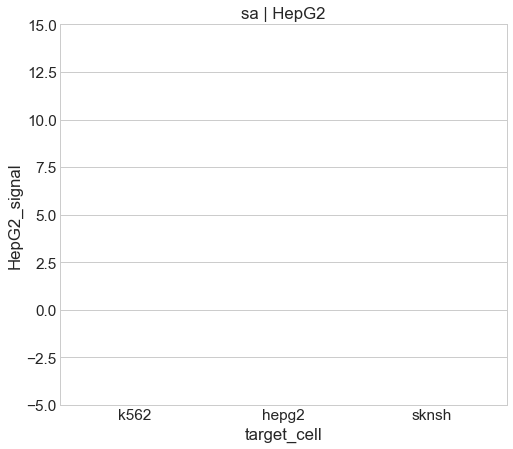

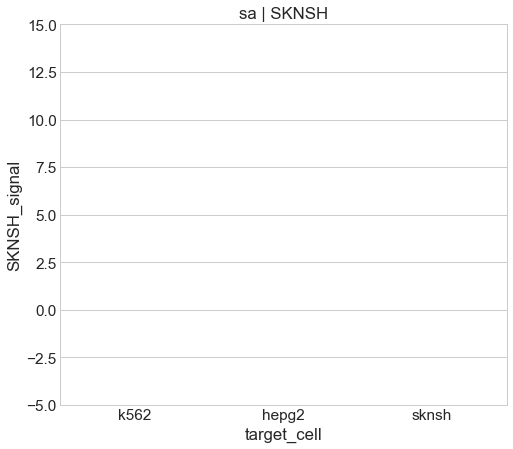

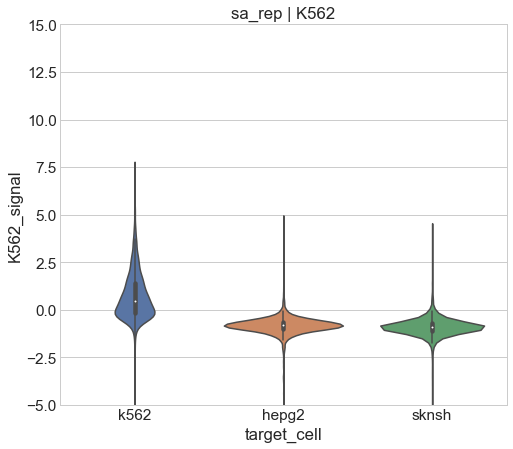

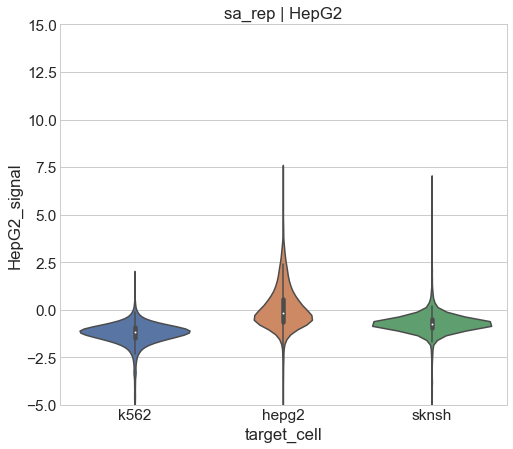

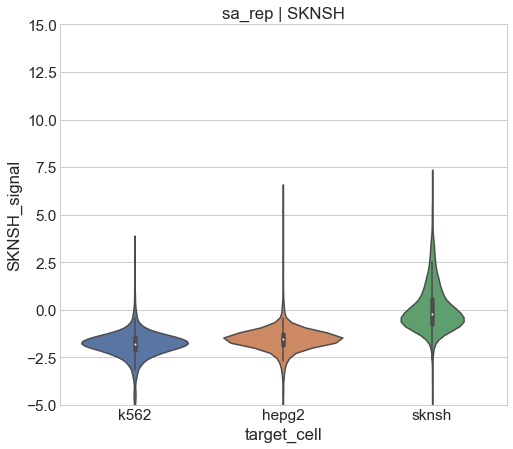

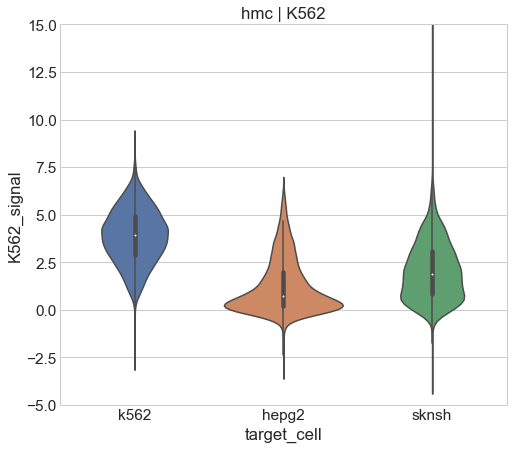

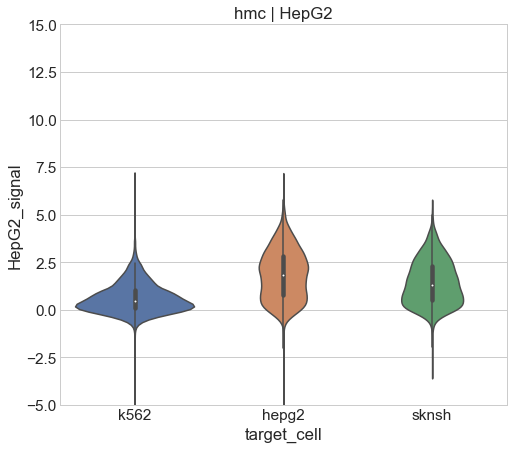

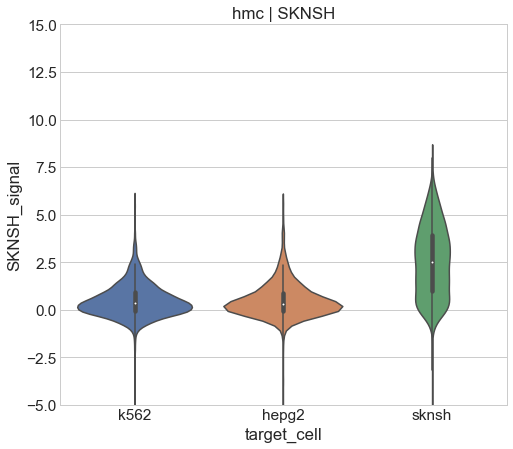

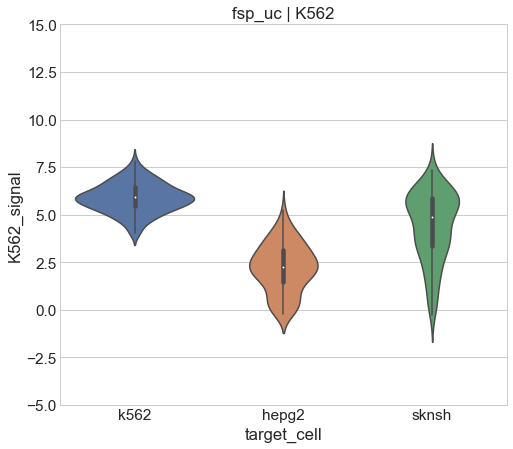

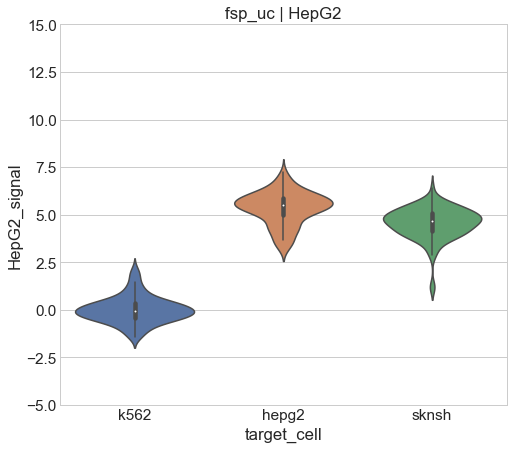

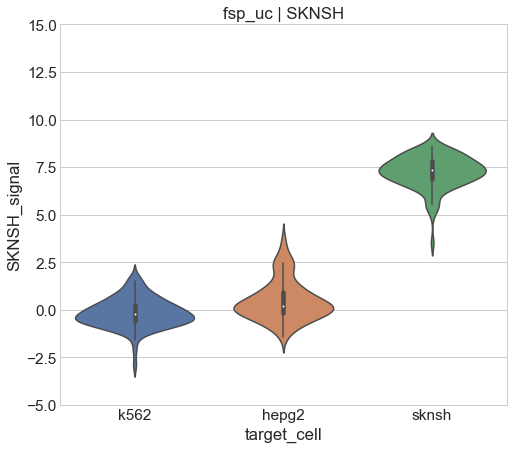

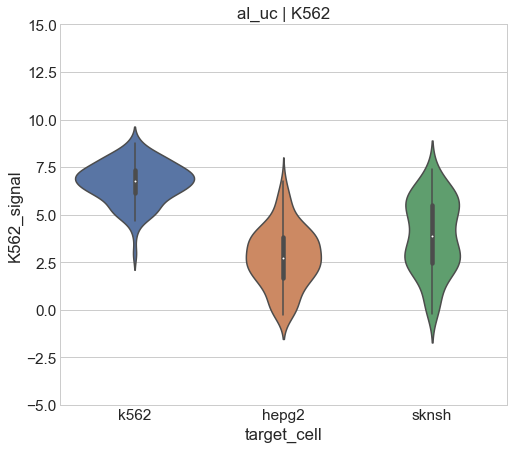

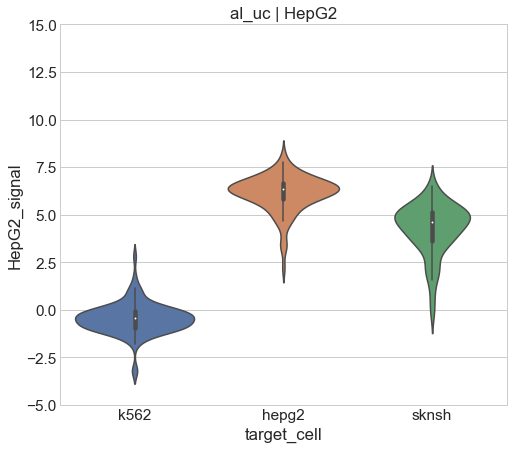

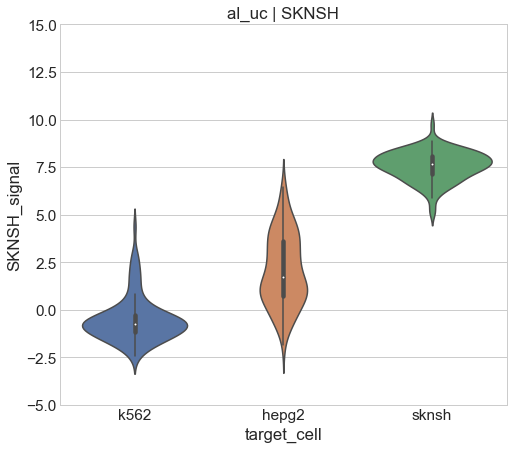

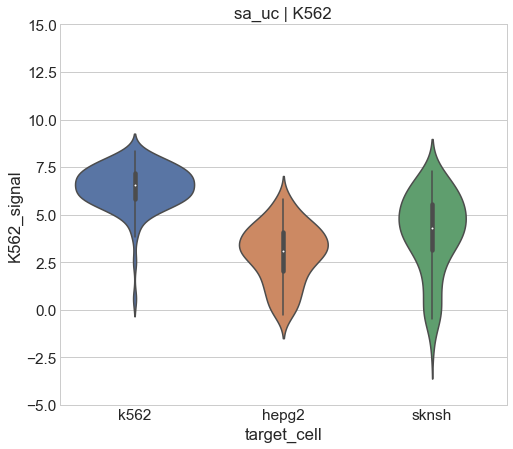

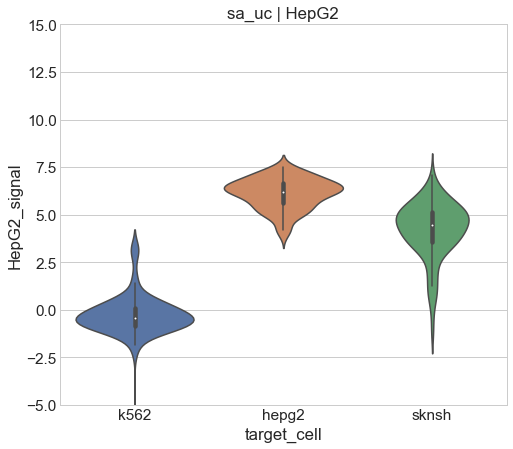

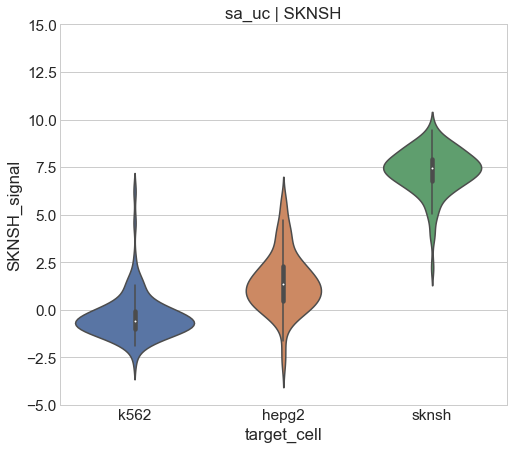

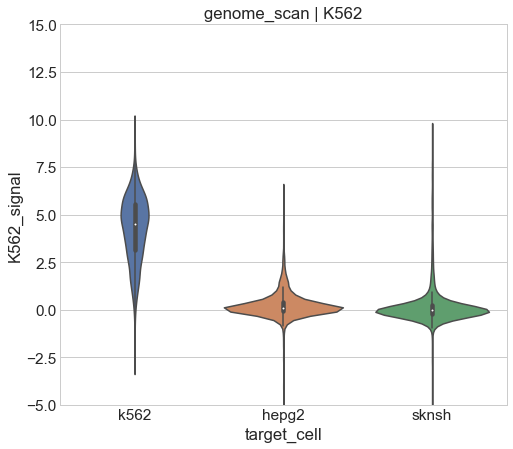

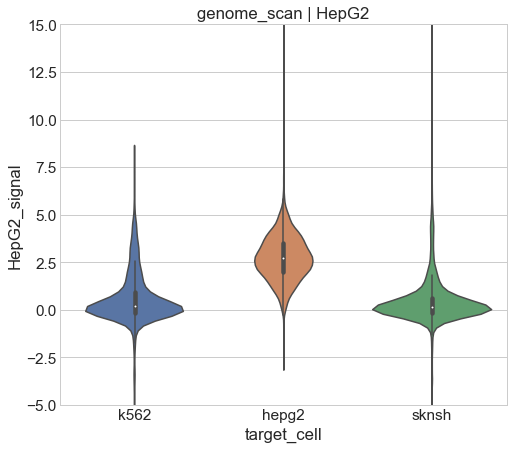

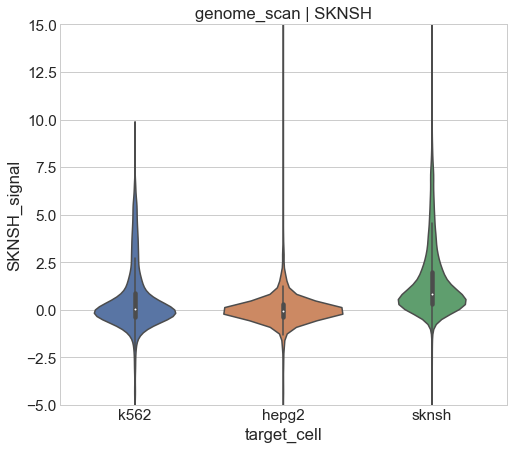

In [5]:
all_methods = ['DHS', 'fsp', 'al', 'sa', 'sa_rep', 'hmc', 'fsp_uc', 'al_uc', 'sa_uc', 'genome_scan']
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
#colormaps = ['winter', 'autumn', 'summer']
sns.set(font_scale = 1.4)
with plt.style.context('seaborn-whitegrid'):
    for method in all_methods:
        if method in ['fsp', 'al', 'sa']:
            row_filter = (boda2_df['method'] == method) & (boda2_df['round'] == '0')
        else:
            row_filter = (boda2_df['method'] == method)
        plot_df = boda2_df[row_filter].copy()
        for color_idx, cell_type in enumerate(cell_types):   
            plt.figure(figsize=(8,7))
#             sns.scatterplot(data=plot_df, x=f'{cell_type}_signal', y=f'{cell_type}_pred', hue='target_cell', s=10.0, alpha=0.5,
#                            hue_order=target_cells)
            sns.violinplot(data=plot_df, x='target_cell', y=f'{cell_type}_signal', inner='box', order=target_cells)
            #plt.plot((-5,15), (-5,-15), color='black', linestyle='--', alpha=0.5)
            #plt.xlim(-5,15)
            plt.ylim(-5,15)
            plt.title(f'{method} | {cell_type}')#, fontsize=16)
            plt.show()

In [97]:
# boda2_df['max_cell_pred'] = boda2_df[['K562_pred', 'HepG2_pred', 'SKNSH_pred']].idxmax(axis=1).str.rstrip('_pred').str.lower()
# boda2_df['max_cell_signal'] = boda2_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']].idxmax(axis=1).str.rstrip('_signal').str.lower()

# boda2_df['round'] = '0'
# row_filter = (boda2_df['method'] == 'fsp') | (boda2_df['method'] == 'sa') | (boda2_df['method'] == 'al') 
# round_list = [split[-1] for split in boda2_df.loc[row_filter, 'ID'].str.split('__').tolist()]
# boda2_df.loc[row_filter, 'round'] = round_list

# out_df = boda2_df.copy()
# out_df.to_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_v2.txt', index=None, sep=' ')

In [121]:
no_controls_df = boda2_df[boda2_df['method'].notnull()].copy().reset_index(drop=True)
rounds_0_df = no_controls_df[no_controls_df['round'] == 0].copy().reset_index(drop=True)

In [116]:
pct_counts = pd.value_counts(no_controls_df.loc[no_controls_df['target_cell'] == no_controls_df['max_cell_signal']]['method']) / pd.value_counts(no_controls_df['method']) * 100

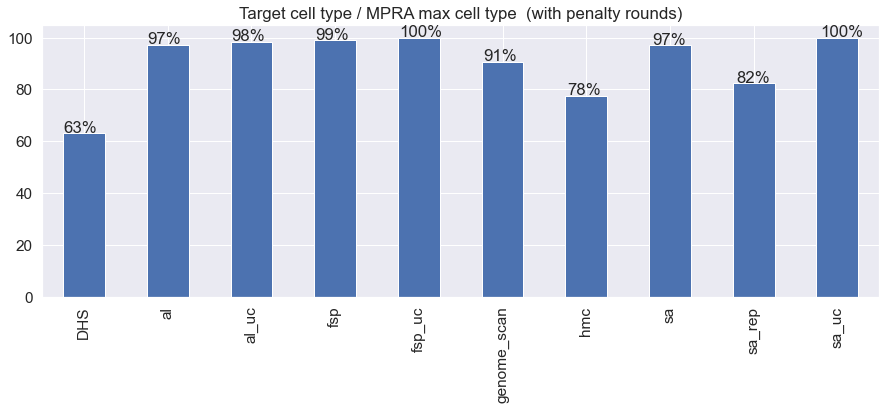

In [117]:
methods = ['DHS', 'genome_scan', 'fsp', 'al', 'sa', 'sa_rep', 'hmc', 'fsp_uc', 'al_uc', 'sa_uc']
mapping = {method: i for i, method in enumerate(methods)}

plt.figure(figsize=(15,5))
ax = pct_counts.sort_index().plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height()))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))

plt.title('Target cell type / MPRA max cell type  (with penalty rounds)')
plt.show()

In [131]:
pct_counts_r0 = pd.value_counts(rounds_0_df.loc[rounds_0_df['target_cell'] == rounds_0_df['max_cell_signal']]['method']) / pd.value_counts(rounds_0_df['method']) * 100

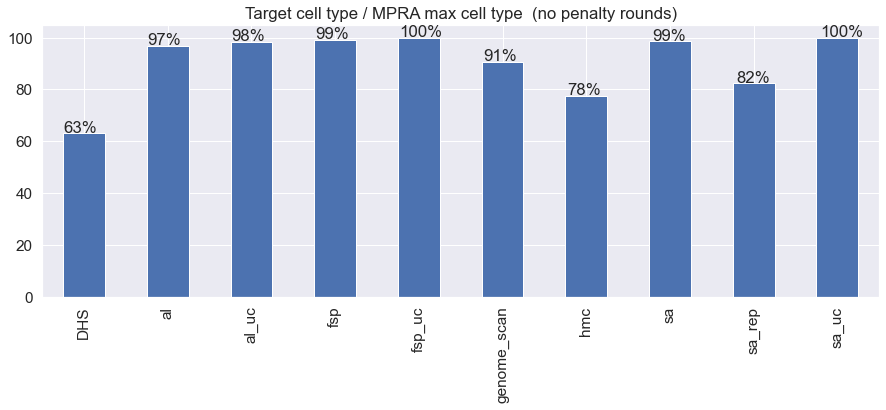

In [322]:
plt.figure(figsize=(15,5))
ax = pct_counts_r0.sort_index().plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height()))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))

plt.title('Target cell type / MPRA max cell type  (no penalty rounds)')
plt.show()

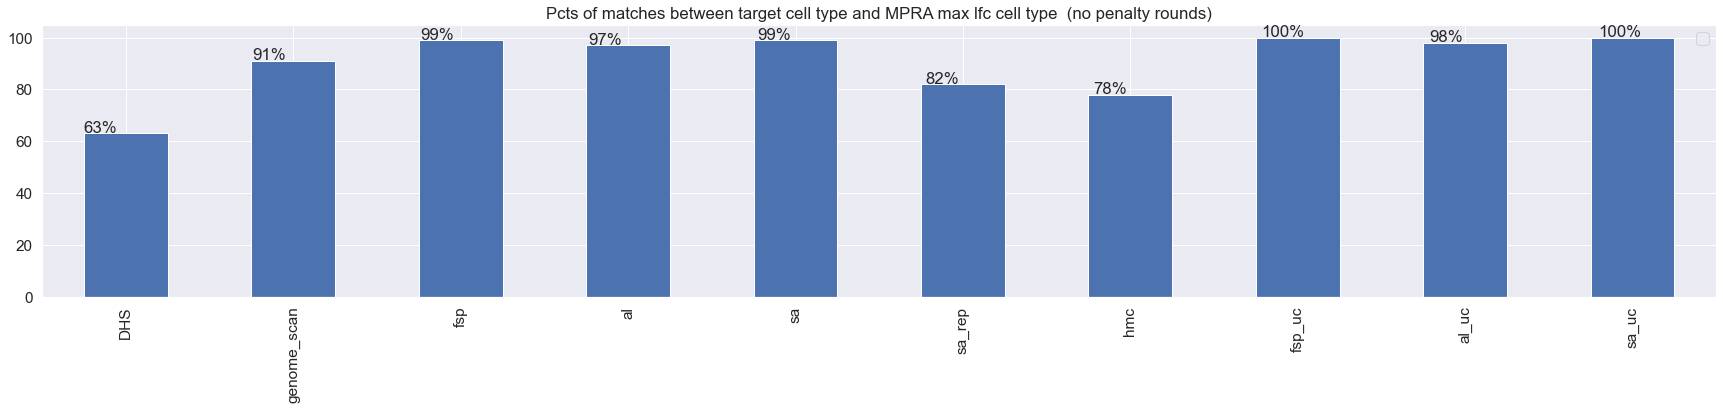

In [361]:
temp_dict = dict(pct_counts_r0)
pcts = []
for method in methods:
    pcts.append(round(temp_dict[method]))
    
out_dict = dict(zip(methods, pcts))

#plt.figure(figsize=(15,5))
ax = pd.DataFrame.from_dict(out_dict, orient='index').plot.bar(figsize=(30,5))
for p in ax.patches:
    ax.annotate(str(round(p.get_height()))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))

plt.title('Pcts of matches between target cell type and MPRA max lfc cell type  (no penalty rounds)')
plt.legend('')
plt.show()

In [133]:
no_controls_df

ID  \
0        20211210_200256__612928__5::fsp_uc__hepg2__0   
1       20211210_200256__612928__12::fsp_uc__hepg2__0   
2       20211210_200256__612928__47::fsp_uc__hepg2__0   
3       20211210_200256__612928__69::fsp_uc__hepg2__0   
4       20211210_200256__612928__93::fsp_uc__hepg2__0   
...                                               ...   
117895                         chr4:49653500-49653700   
117896                        chr20:31056400-31056600   
117897                         chr4:49144600-49144800   
117898                        chr11:82436300-82436500   
117899                        chr20:31100450-31100650   

                                                 sequence  K562_pred  \
0       CAATCTGTTCCCACCATCAGGTTACTGGTTAATCATTAACCAGGGC...  -0.055265   
1       GGAGCTCTTTCAATGCCAGGCAGGCCCGTGGTGCAGTAAAGGCCTG...  -0.019169   
2       GGTTCAAAGTCCAGTCACAGTCCAAAGTCCACTCTTTGTCCAAGAG...  -0.146010   
3       TAATAGTATGTCATCGTAATATGCGGACTTTGAACCGTGTACCAGG...   1.216181   
4       AACACGGGCACGGGGGGGCGCTGTTTGAGTTTAAAAACGATCTAGG...   1.832291   
...                                                   ...        ...   
117895  AATGGAATGGAATGGAATGGAAATGAATGGAATGGAATAACATGCA...  -0.259550   
117896  TGGAATGGAATGAAGGGGAATGGAATGGAATGGAATGCAATGGATT...  -0.139882   
117897  TTCCATTCCATTGCATTCCATACCATTCCATTCCATTCTATTCCAT...  -0.148705   
117898  TCCAGACATAATAACAGGAATGTATACTTCCTGGCCATCAGAGCCT...  -0.138973   
117899  TATAACGGAATGGAATCGAATGGAATTGAATGGAATGGAATAGACT...  -0.431747   

        HepG2_pred  SKNSH_pred  K562_pred_aggreg  HepG2_pred_aggreg  \
0        14.231705    0.080212          0.140002          14.336414   
1        19.914394    0.777519         -0.011601          18.561650   
2        12.227689   -0.400996         -0.034775          10.825762   
3        18.812680    1.589409          1.416824          17.606884   
4        18.612158    1.411221          2.409507          17.280722   
...            ...         ...               ...                ...   
117895   -0.350268    1.980883         -0.238864          -0.339671   
117896   -0.331289    2.217611         -0.154154          -0.320628   
117897    0.614329    3.502213         -0.106589           0.443236   
117898    0.152324    2.755640         -0.078967           0.112190   
117899   -0.520029    1.623662         -0.408189          -0.560953   

        SKNSH_pred_aggreg       project  K562_signal  K562_lfcSE  \
0                0.227027    BODA:hepg2     2.520816    0.316205   
1                0.767500    BODA:hepg2     0.609272    0.285060   
2               -0.337030    BODA:hepg2     1.486130    0.271874   
3                1.713512    BODA:hepg2     2.440630    0.219559   
4                2.059474    BODA:hepg2     3.765216    0.570148   
...                   ...           ...          ...         ...   
117895           1.852794  BODA:genomic    -0.358920    0.247093   
117896           1.972111  BODA:genomic    -0.246672    0.299501   
117897           3.642229  BODA:genomic     2.172089    0.276453   
117898           1.910803  BODA:genomic     0.113179    0.473108   
117899           0.989151  BODA:genomic    -0.136386    0.190184   

        HepG2_signal  HepG2_lfcSE  SKNSH_signal  SKNSH_lfcSE       method  \
0           5.287727     0.309186      0.605723     0.208455       fsp_uc   
1           6.402153     0.301327      0.271218     0.340279       fsp_uc   
2           4.276053     0.366801     -0.578350     0.241865       fsp_uc   
3           5.615395     0.313984      1.063669     0.230603       fsp_uc   
4           4.683140     0.612207      0.171043     2.165178       fsp_uc   
...              ...          ...           ...          ...          ...   
117895     -0.248105     0.266864     -0.112114     0.191480  genome_scan   
117896      0.005176     0.313814      0.564290     0.239431  genome_scan   
117897      2.214319     0.229850      2.428773     0.112830  genome_scan   
117898      0.198963     0.442636      1.103688     0.437283 

In [134]:
nontarget_dict = {'k562': ['HepG2_signal', 'SKNSH_signal'],
                 'hepg2': ['K562_signal', 'SKNSH_signal'],
                 'sknsh': ['K562_signal', 'HepG2_signal']}

target_dict = {'k562': 'K562_signal',
              'hepg2': 'HepG2_signal',
              'sknsh': 'SKNSH_signal'}

In [175]:
nontarget_list = []
for i in tqdm(range(len(no_controls_df))):
    temp_row = no_controls_df.iloc[[i]]
    nontarget_list.append(temp_row[nontarget_dict[temp_row['target_cell'].item()]].idxmax(axis=1).item())

  0%|          | 0/117900 [00:00<?, ?it/s]

In [189]:
no_controls_df['max_non_target_cell'] = [item.rstrip('_signal').lower() if (type(item) == str) else np.nan for item in nontarget_list]

In [190]:
nontarget_lfc_list = []
for i in tqdm(range(len(no_controls_df))):
    temp_row = no_controls_df.iloc[[i]]
    nontarget_lfc_list.append(temp_row[nontarget_dict[temp_row['target_cell'].item()]].max(axis=1).item())

  0%|          | 0/117900 [00:00<?, ?it/s]

In [193]:
no_controls_df['max_non_target_lfc'] = [item if (type(item) == float) else np.nan for item in nontarget_lfc_list]

In [195]:
nontarget_min_list = []
for i in tqdm(range(len(no_controls_df))):
    temp_row = no_controls_df.iloc[[i]]
    nontarget_min_list.append(temp_row[nontarget_dict[temp_row['target_cell'].item()]].idxmin(axis=1).item())

  0%|          | 0/117900 [00:00<?, ?it/s]

In [196]:
no_controls_df['min_non_target_cell'] = [item.rstrip('_signal').lower() if (type(item) == str) else np.nan for item in nontarget_min_list]

In [202]:
nontarget_min_lfc_list = []
for i in tqdm(range(len(no_controls_df))):
    temp_row = no_controls_df.iloc[[i]]
    nontarget_min_lfc_list.append(temp_row[nontarget_dict[temp_row['target_cell'].item()]].min(axis=1).item())

  0%|          | 0/117900 [00:00<?, ?it/s]

In [203]:
no_controls_df['min_non_target_lfc'] = [item if (type(item) == float) else np.nan for item in nontarget_min_lfc_list]

In [199]:
target_lfc_list = []
for i in tqdm(range(len(no_controls_df))):
    temp_row = no_controls_df.iloc[[i]]
    target_lfc_list.append(temp_row[target_dict[temp_row['target_cell'].item()]].item())

  0%|          | 0/117900 [00:00<?, ?it/s]

In [204]:
no_controls_df['target_cell_lfc'] = [item if (type(item) == float) else np.nan for item in target_lfc_list]

In [207]:
no_controls_df.columns

Index(['ID', 'sequence', 'K562_pred', 'HepG2_pred', 'SKNSH_pred',
       'K562_pred_aggreg', 'HepG2_pred_aggreg', 'SKNSH_pred_aggreg', 'project',
       'K562_signal', 'K562_lfcSE', 'HepG2_signal', 'HepG2_lfcSE',
       'SKNSH_signal', 'SKNSH_lfcSE', 'method', 'target_cell', 'round',
       'max_cell_pred', 'max_cell_signal', 'max_non_target_cell',
       'max_non_target_lfc', 'min_non_target_cell', 'min_non_target_lfc',
       'target_cell_lfc'],
      dtype='object')

In [210]:
to_attach_df = no_controls_df[['ID', 'max_non_target_cell',
       'max_non_target_lfc', 'min_non_target_cell', 'min_non_target_lfc',
       'target_cell_lfc']]

In [212]:
# out_df = boda2_df.merge(to_attach_df, how='outer', on='ID').copy()
# out_df.to_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_v3.txt', index=None, sep=' ')

In [214]:
no_controls_df['seq_len'] = no_controls_df.progress_apply(lambda x: len(x['sequence']), axis=1)

  0%|          | 0/117900 [00:00<?, ?it/s]

In [261]:
no_controls_df['over_max'] = no_controls_df['target_cell_lfc'] - no_controls_df['max_non_target_lfc']
no_controls_df['non_target_lfc_mean'] = 0.5*(no_controls_df['max_non_target_lfc'] + no_controls_df['min_non_target_lfc'])
no_controls_df['tau'] = no_controls_df['target_cell_lfc'] - no_controls_df['non_target_lfc_mean']

In [262]:
rounds_0_df = no_controls_df[no_controls_df['round'] == 0].copy().reset_index(drop=True)

In [219]:
rounds_0_df

ID  \
0       20211210_200256__612928__5::fsp_uc__hepg2__0   
1      20211210_200256__612928__12::fsp_uc__hepg2__0   
2      20211210_200256__612928__47::fsp_uc__hepg2__0   
3      20211210_200256__612928__69::fsp_uc__hepg2__0   
4      20211210_200256__612928__93::fsp_uc__hepg2__0   
...                                              ...   
84895                         chr4:49653500-49653700   
84896                        chr20:31056400-31056600   
84897                         chr4:49144600-49144800   
84898                        chr11:82436300-82436500   
84899                        chr20:31100450-31100650   

                                                sequence  K562_pred  \
0      CAATCTGTTCCCACCATCAGGTTACTGGTTAATCATTAACCAGGGC...  -0.055265   
1      GGAGCTCTTTCAATGCCAGGCAGGCCCGTGGTGCAGTAAAGGCCTG...  -0.019169   
2      GGTTCAAAGTCCAGTCACAGTCCAAAGTCCACTCTTTGTCCAAGAG...  -0.146010   
3      TAATAGTATGTCATCGTAATATGCGGACTTTGAACCGTGTACCAGG...   1.216181   
4      AACACGGGCACGGGGGGGCGCTGTTTGAGTTTAAAAACGATCTAGG...   1.832291   
...                                                  ...        ...   
84895  AATGGAATGGAATGGAATGGAAATGAATGGAATGGAATAACATGCA...  -0.259550   
84896  TGGAATGGAATGAAGGGGAATGGAATGGAATGGAATGCAATGGATT...  -0.139882   
84897  TTCCATTCCATTGCATTCCATACCATTCCATTCCATTCTATTCCAT...  -0.148705   
84898  TCCAGACATAATAACAGGAATGTATACTTCCTGGCCATCAGAGCCT...  -0.138973   
84899  TATAACGGAATGGAATCGAATGGAATTGAATGGAATGGAATAGACT...  -0.431747   

       HepG2_pred  SKNSH_pred  K562_pred_aggreg  HepG2_pred_aggreg  \
0       14.231705    0.080212          0.140002          14.336414   
1       19.914394    0.777519         -0.011601          18.561650   
2       12.227689   -0.400996         -0.034775          10.825762   
3       18.812680    1.589409          1.416824          17.606884   
4       18.612158    1.411221          2.409507          17.280722   
...           ...         ...               ...                ...   
84895   -0.350268    1.980883         -0.238864          -0.339671   
84896   -0.331289    2.217611         -0.154154          -0.320628   
84897    0.614329    3.502213         -0.106589           0.443236   
84898    0.152324    2.755640         -0.078967           0.112190   
84899   -0.520029    1.623662         -0.408189          -0.560953   

       SKNSH_pred_aggreg       project  K562_signal  K562_lfcSE  HepG2_signal  \
0               0.227027    BODA:hepg2     2.520816    0.316205      5.287727   
1               0.767500    BODA:hepg2     0.609272    0.285060      6.402153   
2              -0.337030    BODA:hepg2     1.486130    0.271874      4.276053   
3               1.713512    BODA:hepg2     2.440630    0.219559      5.615395   
4               2.059474    BODA:hepg2     3.765216    0.570148      4.683140   
...                  ...           ...          ...         ...           ...   
84895           1.852794  BODA:genomic    -0.358920    0.247093     -0.248105   
84896           1.972111  BODA:genomic    -0.246672    0.299501      0.005176   
84897           3.642229  BODA:genomic     2.172089    0.276453      2.214319   
84898           1.910803  BODA:genomic     0.113179    0.473108      0.198963   
84899           0.989151  BODA:genomic    -0.136386    0.190184     -0.598509   

       HepG2_lfcSE  SKNSH_signal  SKNSH_lfcSE       method target_cell  round  \
0         0.309186      0.605723     0.208455       fsp_uc       hepg2      0   
1         0.301327      0.271218     0.340279       fsp_uc       hepg2      0   
2         0.366801     -0.578350     0.241865       fsp_uc       hepg2      0   
3         0.313984      1.063669     0.230603       fsp_uc       hepg2      0   
4         0.612207      0.171043     2.165178       fsp_uc       hepg2      0   
...            ...           ...          ...          ...         ...    ...   
84895     0.266864     -0.112114     0.191480  genome_scan       sknsh      0   
84896     0.313814      0.564290     0.239431  genome_scan    

In [236]:
rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0

0         True
1         True
2         True
3         True
4        False
         ...  
84895     True
84896     True
84897     True
84898     True
84899     True
Length: 84900, dtype: bool

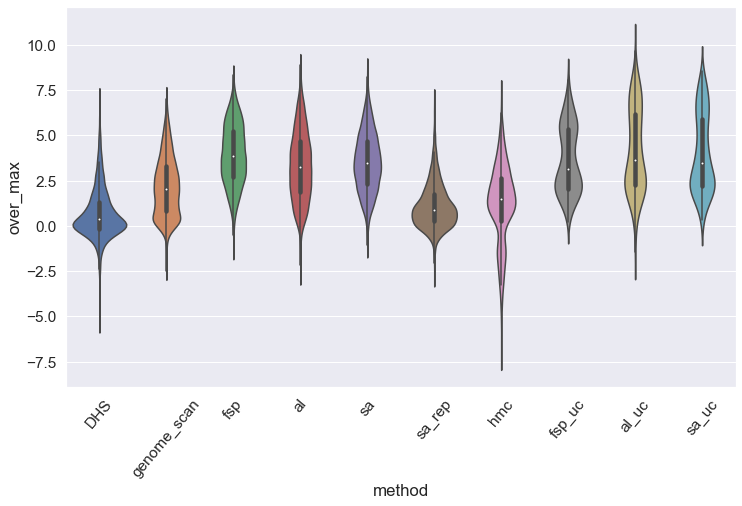

In [237]:
plt.figure(figsize=(12,7))
plot_df = rounds_0_df
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)

sns.violinplot(data=plot_df[quality_filter], x='method', y='over_max', inner='box', order=methods)
plt.xticks(rotation=50)
plt.show()

<Figure size 1440x1440 with 0 Axes>

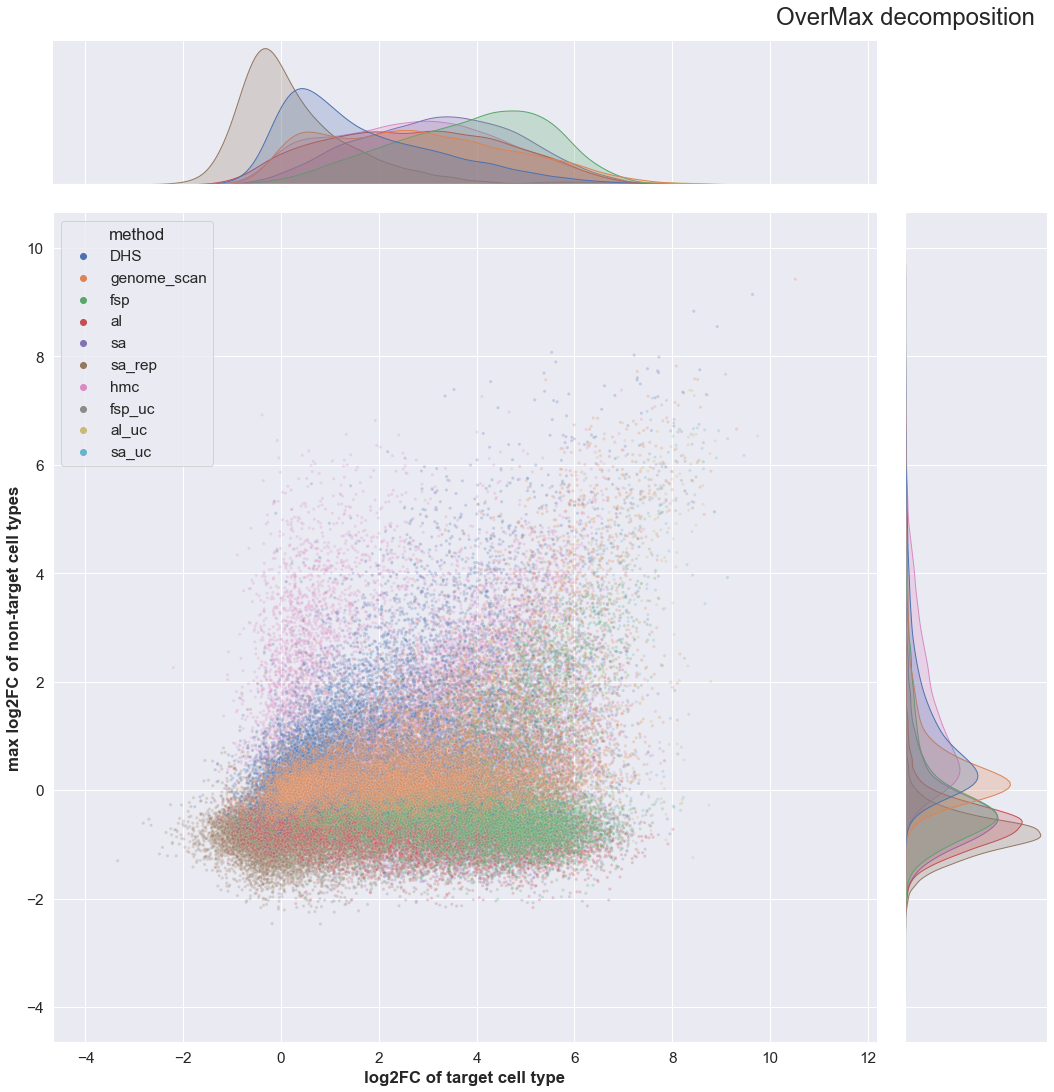

In [320]:
plt.figure(figsize=(20,20))
plot_df = rounds_0_df
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)

h = sns.jointplot(data=plot_df[quality_filter], x='target_cell_lfc', y='max_non_target_lfc', hue='method', alpha=0.25, height=15, hue_order=methods, s=10)
h.ax_joint.set_xlabel('log2FC of target cell type', fontweight='bold')
h.ax_joint.set_ylabel('max log2FC of non-target cell types', fontweight='bold')
plt.title('OverMax decomposition', y=1.22, x=0.0, fontsize = 24)
plt.show()

<Figure size 1440x1440 with 0 Axes>

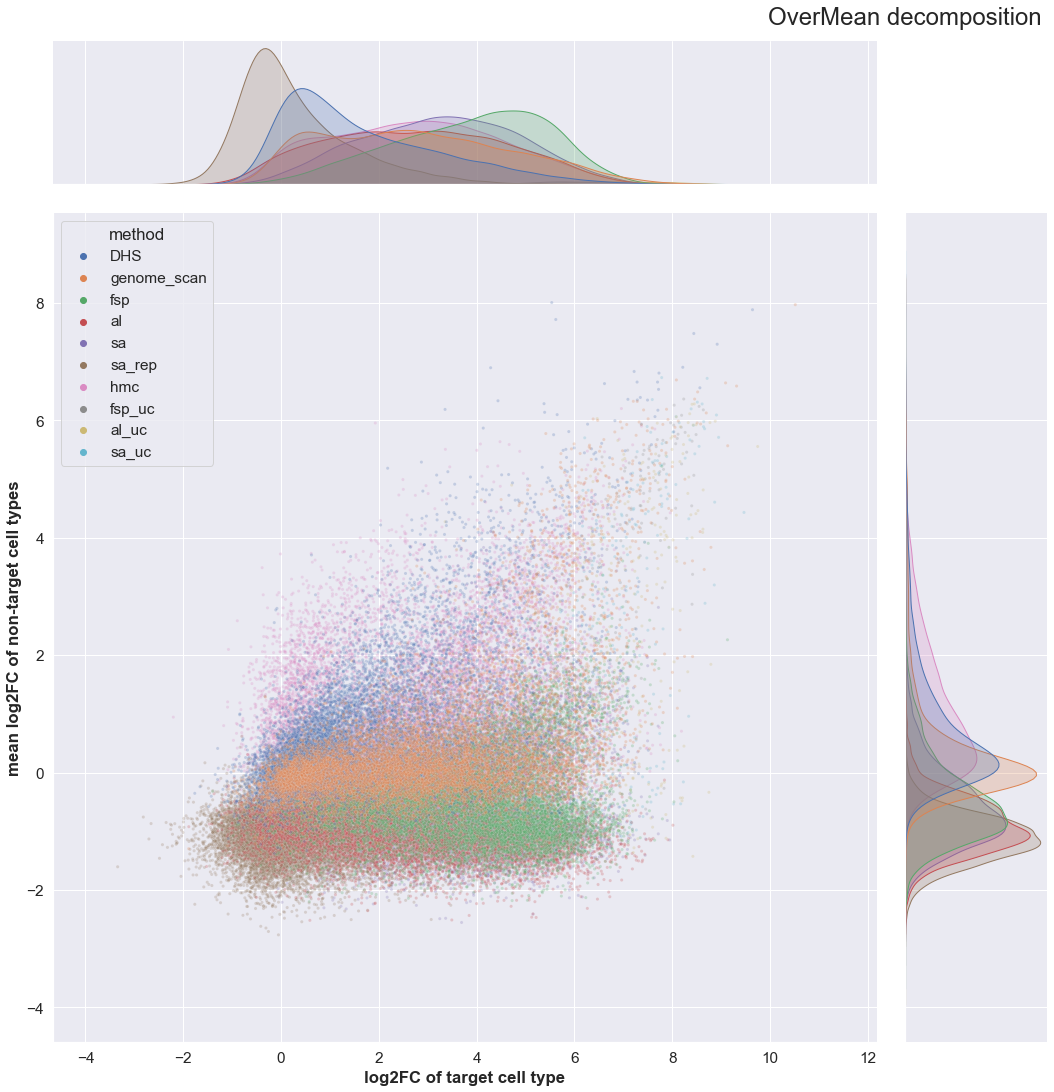

In [321]:
plt.figure(figsize=(20,20))
plot_df = rounds_0_df
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)

h = sns.jointplot(data=plot_df[quality_filter], x='target_cell_lfc', y='non_target_lfc_mean', hue='method', alpha=0.25, height=15, hue_order=methods, s=10)
h.ax_joint.set_xlabel('log2FC of target cell type', fontweight='bold')
h.ax_joint.set_ylabel('mean log2FC of non-target cell types', fontweight='bold')
plt.title('OverMean decomposition', y=1.22, x=0.0, fontsize = 24)
plt.show()

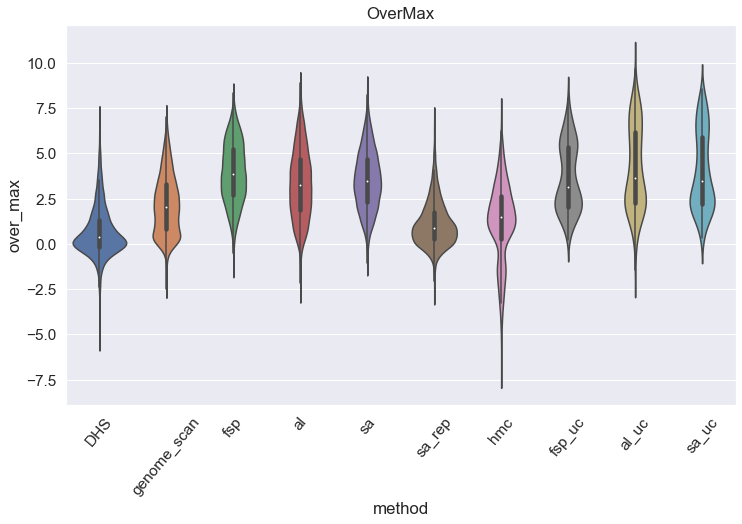

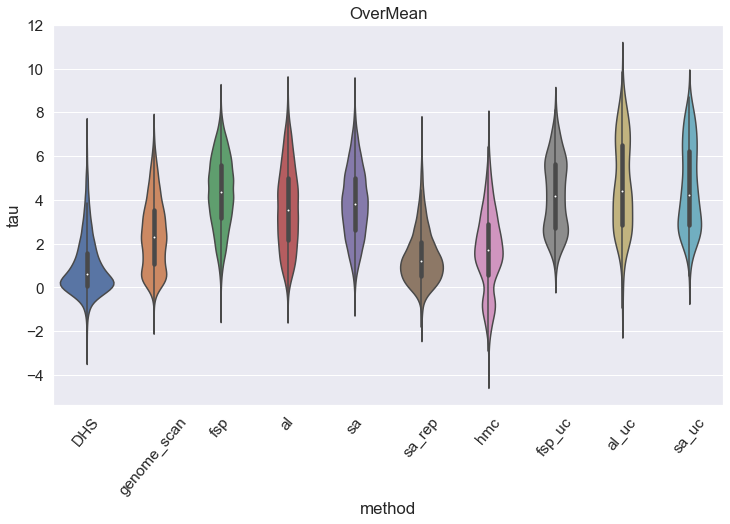

In [285]:
plt.figure(figsize=(12,7))
plot_df = rounds_0_df
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)

sns.violinplot(data=plot_df[quality_filter], x='method', y='over_max', inner='box', order=methods)
plt.xticks(rotation=50)
plt.title('OverMax')
plt.show()

plt.figure(figsize=(12,7))
plot_df = rounds_0_df
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)

sns.violinplot(data=plot_df[quality_filter], x='method', y='tau', inner='box', order=methods)
plt.xticks(rotation=50)
plt.title('OverMean')
plt.show()


In [303]:
# def bending(x):
#     return x - (np.exp(x) - 1)

# rounds_0_df['over_max_b'] = bending(rounds_0_df['target_cell_lfc']) - bending(rounds_0_df['max_non_target_lfc']) 

# plt.figure(figsize=(12,7))
# plot_df = rounds_0_df
# quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) & (np.abs(rounds_0_df['Over_max_b']) < 10)

# sns.violinplot(data=plot_df[quality_filter], x='method', y='over_max_b', inner='box', order=methods)
# plt.xticks(rotation=50)
# plt.title('OverMaxB')
# plt.show()

# rounds_0_df.drop('Over_max_b', axis=1, inplace=True)

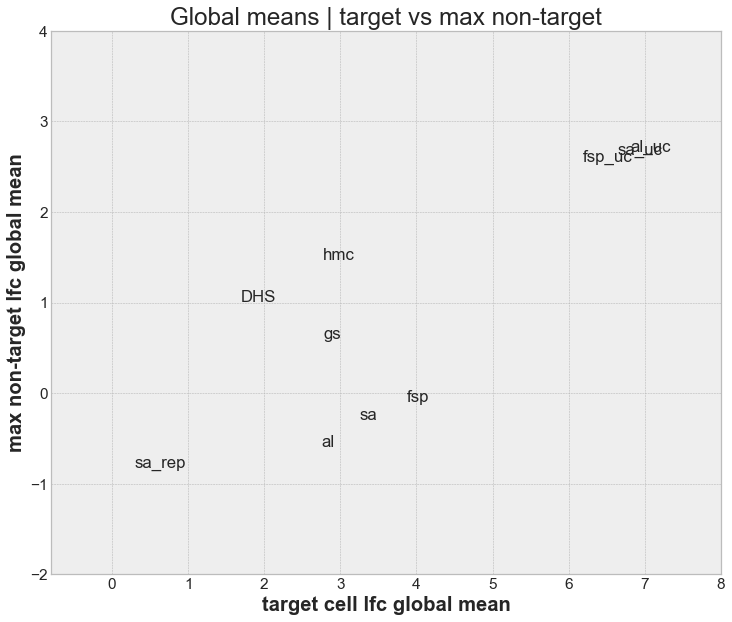

In [442]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = rounds_0_df[quality_filter]

y_dict = dict(plot_df.groupby('method')['max_non_target_lfc'].mean())
x_dict = dict(plot_df.groupby('method')['target_cell_lfc'].mean())

with plt.style.context('bmh'):
    plt.figure(figsize=(12,10))
    x_max, y_max = max(x_dict.values()), max(y_dict.values())
    x_min, y_min = min(x_dict.values()), min(y_dict.values())

    for method in methods:
        if method=='genome_scan': text = 'gs'
        else: text = method
        plt.text(x_dict[method], y_dict[method], text)

#     plt.xlim(x_min - 1, x_max + 1)
#     plt.ylim(y_min - 1, y_max + 1)
    plt.xlim(-0.8, 8)
    plt.ylim(-2, 4)
    plt.xlabel('target cell lfc global mean', fontweight='bold')
    plt.ylabel('max non-target lfc global mean', fontweight='bold')
    plt.title('Global means | target vs max non-target')
    plt.show()

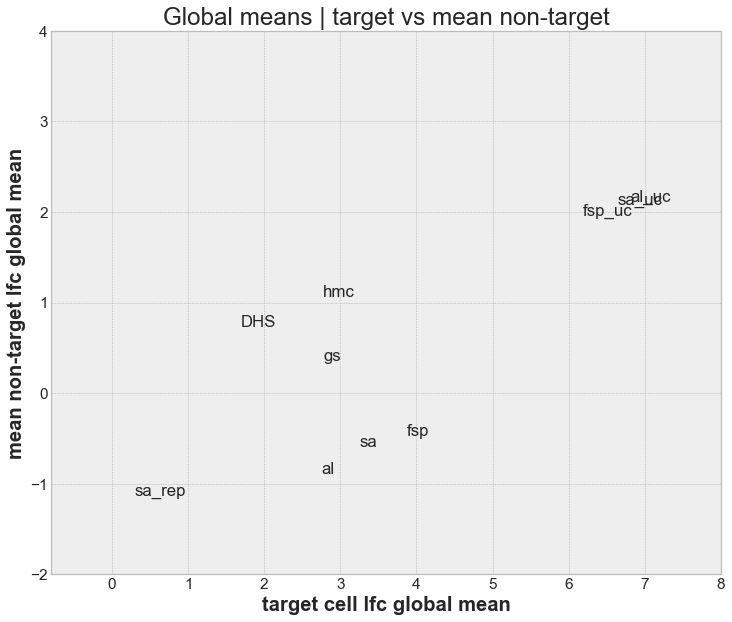

In [443]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = rounds_0_df[quality_filter]

y_dict = dict(plot_df.groupby('method')['non_target_lfc_mean'].mean())
x_dict = dict(plot_df.groupby('method')['target_cell_lfc'].mean())

with plt.style.context('bmh'):
    plt.figure(figsize=(12,10))
    x_max, y_max = max(x_dict.values()), max(y_dict.values())
    x_min, y_min = min(x_dict.values()), min(y_dict.values())

    for method in methods:
        if method=='genome_scan': text = 'gs'
        else: text = method
        plt.text(x_dict[method], y_dict[method], text)

#     plt.xlim(x_min - 1, x_max + 1)
#     plt.ylim(y_min - 1, y_max + 1)
    plt.xlim(-0.8, 8)
    plt.ylim(-2, 4)
    plt.xlabel('target cell lfc global mean', fontweight='bold')
    plt.ylabel('mean non-target lfc global mean', fontweight='bold')
    plt.title('Global means | target vs mean non-target')
    plt.show()

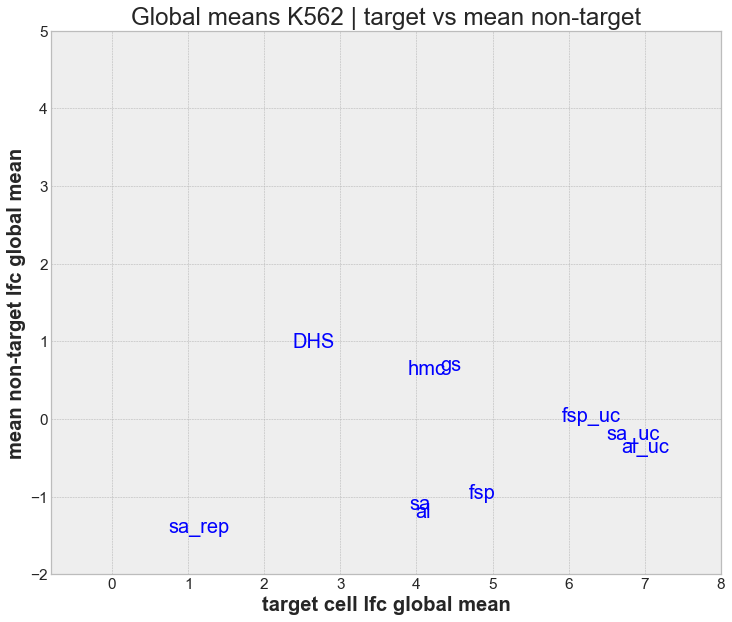

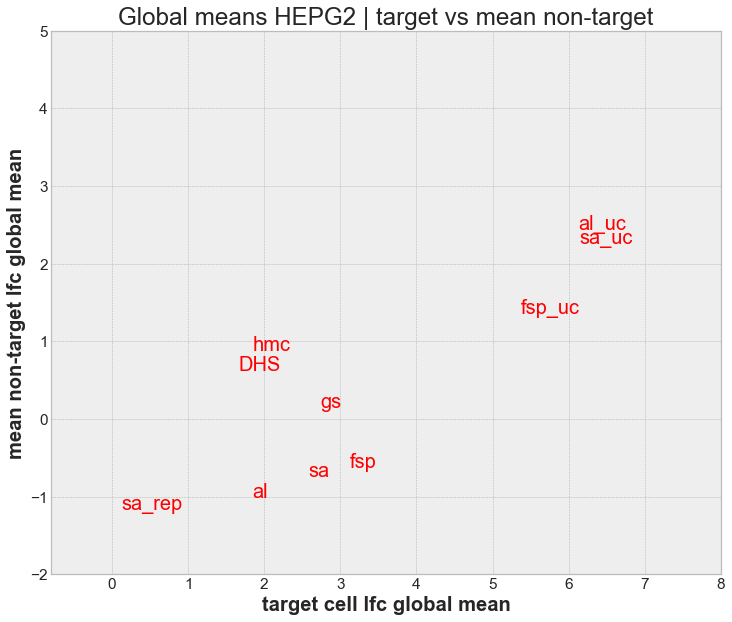

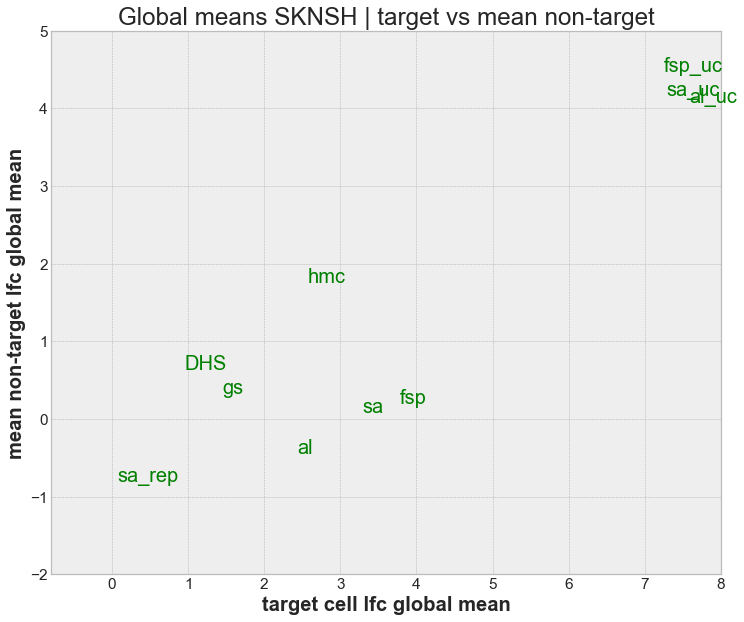

In [445]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = rounds_0_df[quality_filter]

cell_colors = {'k562':'blue', 'hepg2':'red', 'sknsh':'green'}
for cell_type in ['k562', 'hepg2', 'sknsh']:
    y_dict = dict(plot_df.loc[plot_df['target_cell'] == cell_type].groupby('method')['non_target_lfc_mean'].mean())
    x_dict = dict(plot_df.loc[plot_df['target_cell'] == cell_type].groupby('method')['target_cell_lfc'].mean())

    with plt.style.context('bmh'):
        plt.figure(figsize=(12,10))
        x_max, y_max = max(x_dict.values()), max(y_dict.values())
        x_min, y_min = min(x_dict.values()), min(y_dict.values())

        for method in methods:
            if method=='genome_scan': text = 'gs'
            else: text = method
            plt.text(x_dict[method], y_dict[method], text, fontsize=20, color=cell_colors[cell_type])

        #plt.xlim(x_min - 1, x_max + 1)
        #plt.ylim(y_min - 1, y_max + 1)
        plt.xlim(-0.8, 8)
        plt.ylim(-2, 5)
        plt.xlabel('target cell lfc global mean', fontweight='bold')
        plt.ylabel('mean non-target lfc global mean', fontweight='bold')
        plt.title(f'Global means {cell_type.upper()} | target vs mean non-target')
        plt.show()

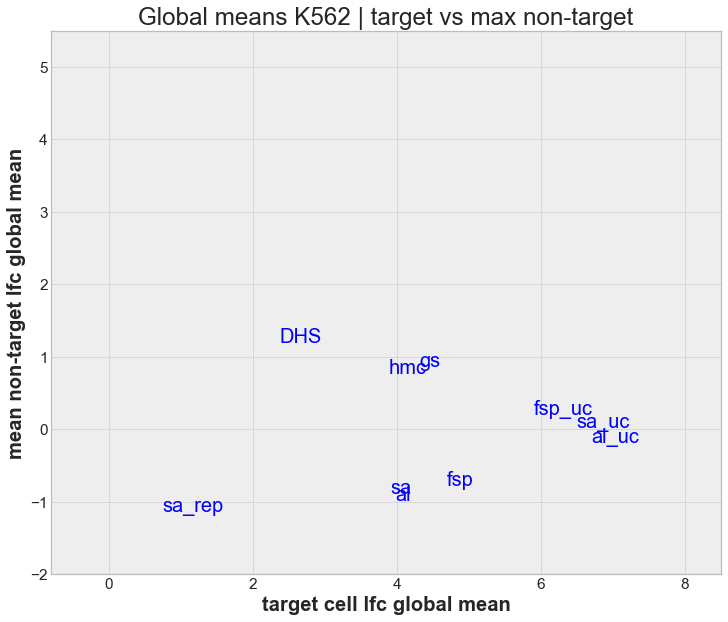

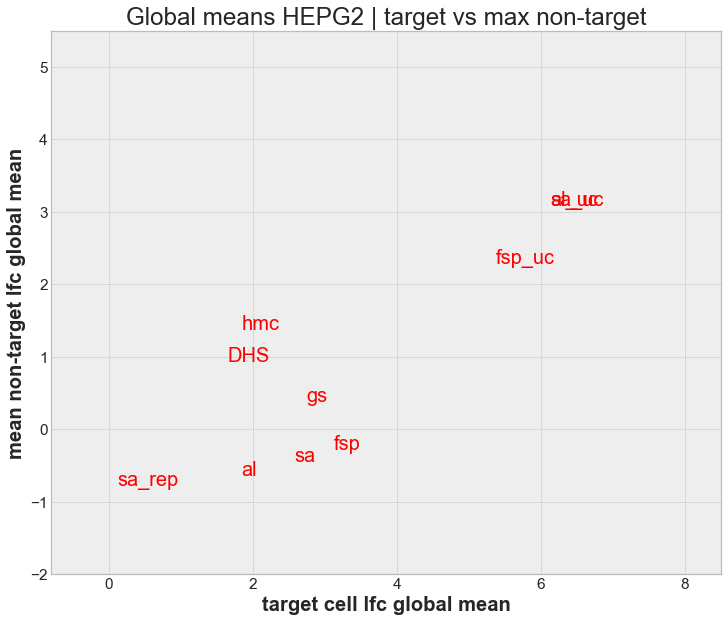

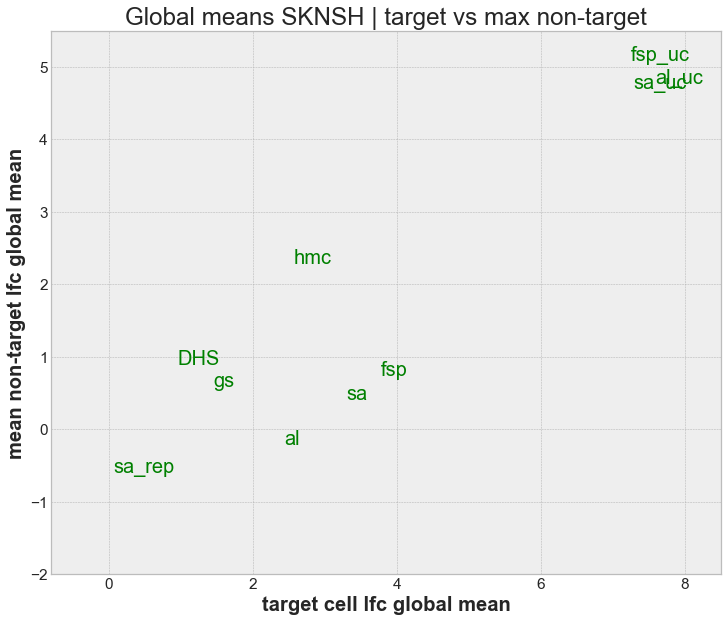

In [447]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = rounds_0_df[quality_filter]

cell_colors = {'k562':'blue', 'hepg2':'red', 'sknsh':'green'}
for cell_type in ['k562', 'hepg2', 'sknsh']:
    y_dict = dict(plot_df.loc[plot_df['target_cell'] == cell_type].groupby('method')['max_non_target_lfc'].mean())
    x_dict = dict(plot_df.loc[plot_df['target_cell'] == cell_type].groupby('method')['target_cell_lfc'].mean())

    with plt.style.context('bmh'):
        plt.figure(figsize=(12,10))
        x_max, y_max = max(x_dict.values()), max(y_dict.values())
        x_min, y_min = min(x_dict.values()), min(y_dict.values())

        for method in methods:
            if method=='genome_scan': text = 'gs'
            else: text = method
            plt.text(x_dict[method], y_dict[method], text, fontsize=20, color=cell_colors[cell_type])

        #plt.xlim(x_min - 1, x_max + 1)
        #plt.ylim(y_min - 1, y_max + 1)
        plt.xlim(-0.8, 8.5)
        plt.ylim(-2, 5.5)
        plt.xlabel('target cell lfc global mean', fontweight='bold')
        plt.ylabel('mean non-target lfc global mean', fontweight='bold')
        plt.title(f'Global means {cell_type.upper()} | target vs max non-target')
        plt.show()

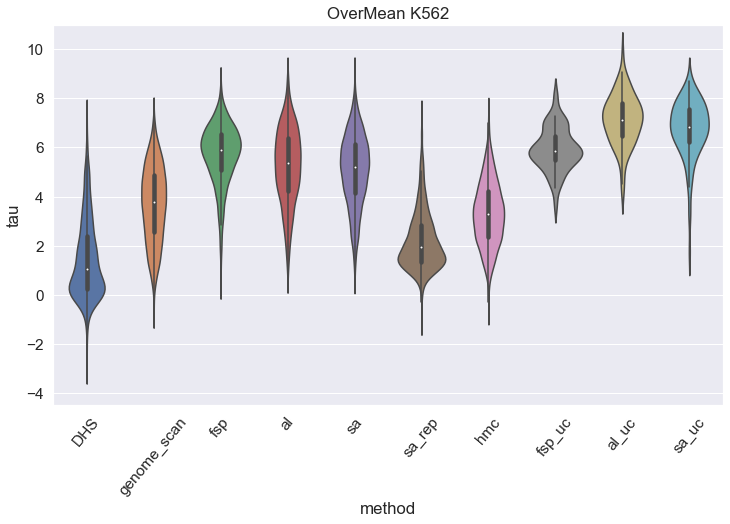

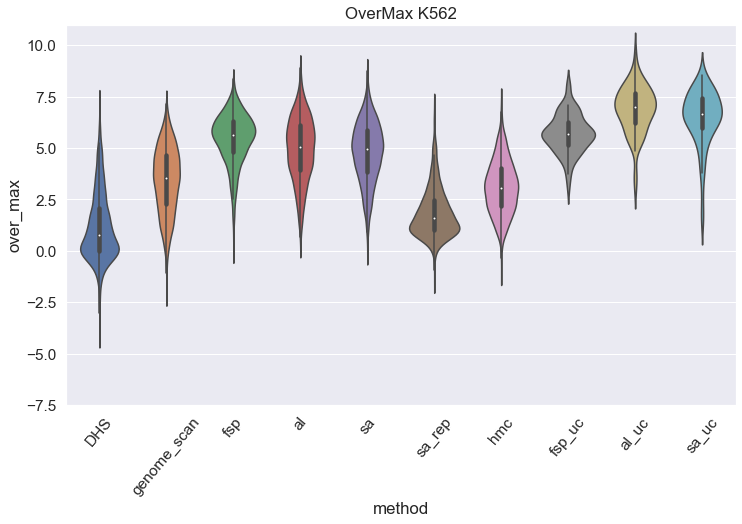

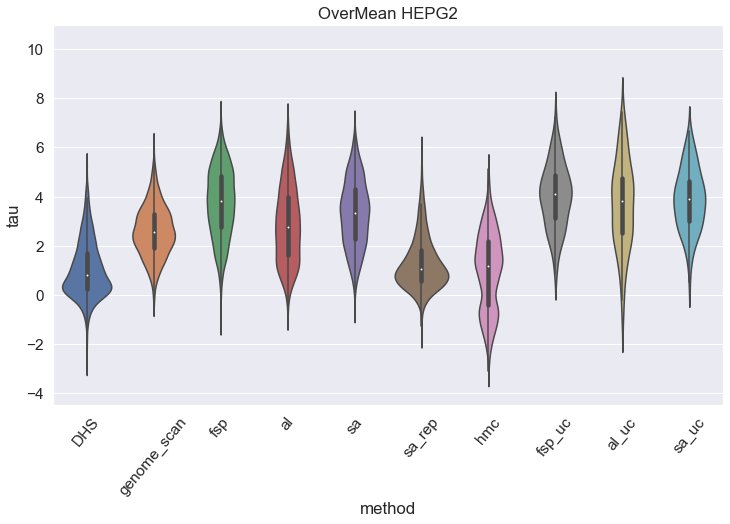

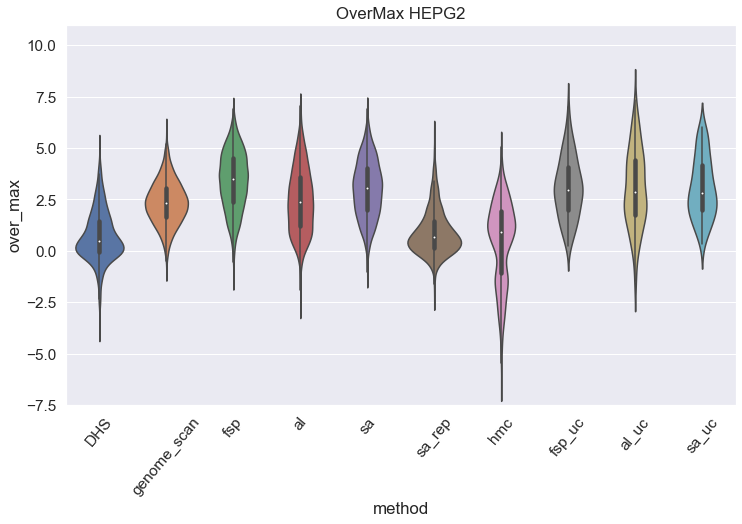

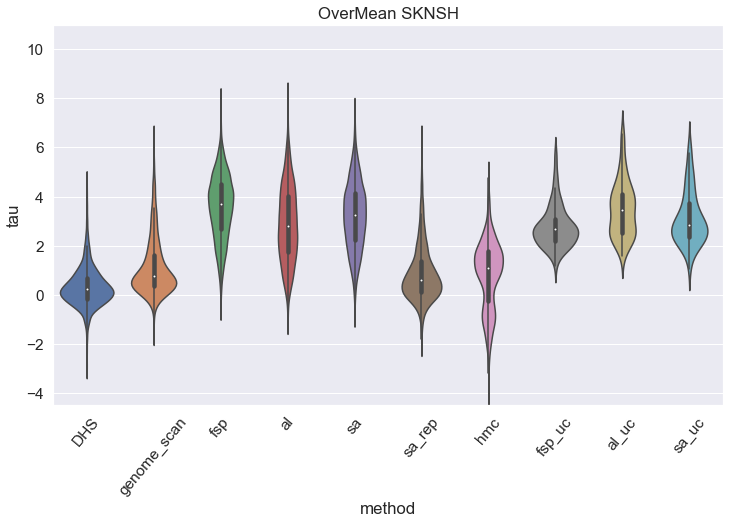

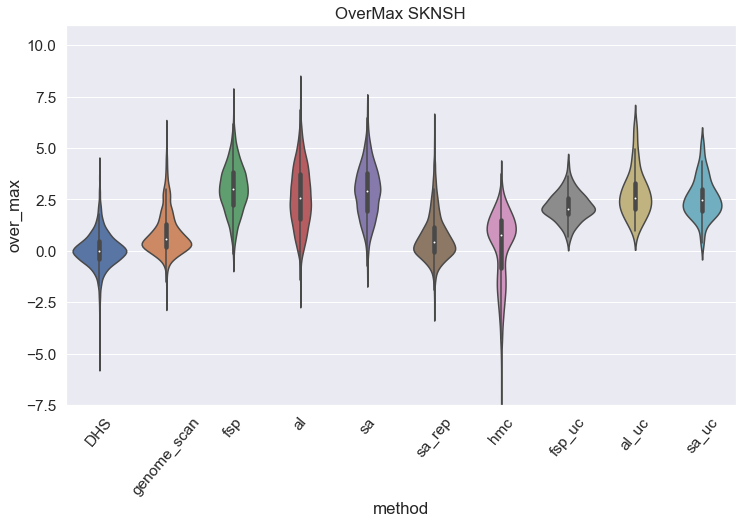

In [456]:
for cell_type in ['k562', 'hepg2', 'sknsh']:
    plt.figure(figsize=(12,7))
    plot_df = rounds_0_df[rounds_0_df['target_cell'] == cell_type].copy()
    quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
    sns.violinplot(data=plot_df[quality_filter], x='method', y='tau', inner='box', order=methods)
    plt.xticks(rotation=50)
    plt.title(f'OverMean {cell_type.upper()}')
    plt.ylim(-4.5, 11)
    plt.show()
    
    plt.figure(figsize=(12,7))
    plot_df = rounds_0_df[rounds_0_df['target_cell'] == cell_type].copy()
    quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
    sns.violinplot(data=plot_df[quality_filter], x='method', y='over_max', inner='box', order=methods)
    plt.xticks(rotation=50)
    plt.title(f'OverMax {cell_type.upper()}')
    plt.ylim(-7.5, 11)
    plt.show()
